In [1]:
library(dplyr)
library(ggplot2)
library(ggpubr)
library(ggsignif)
library(ggrepel)
library(tidyverse)
library(reshape)
# library(glmnet)
library(compositions)
library(zCompositions)



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ tibble  3.1.2     ✔ purrr   0.3.4
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘reshape’


The following objects are masked from ‘package:tidyr’:

    expand, smiths


The following object is masked from ‘package:dplyr’:

    rename


Welcome to compositions, a package for compositional data analysis.
Find an intro with "? compositions"



Attaching package: ‘compositions’


The following objects are masked from ‘package:stats’:

    anova, cor, cov, dist, var


The following objects are masked from ‘pa

In [2]:
sessionInfo()

R version 3.6.1 (2019-07-05)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Red Hat Enterprise Linux 9.4 (Plow)

Matrix products: default
BLAS/LAPACK: /fast/AG_Huebner/GUIX_PROFILES/conda_envs/scanpy_151/lib/R/lib/libRblas.so

locale:
 [1] LC_CTYPE=en_GB.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_GB.UTF-8        LC_COLLATE=en_GB.UTF-8    
 [5] LC_MONETARY=en_GB.UTF-8    LC_MESSAGES=en_GB.UTF-8   
 [7] LC_PAPER=en_GB.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_GB.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] zCompositions_1.3.4 truncnorm_1.0-8     NADA_1.6-1.1       
 [4] survival_3.2-7      MASS_7.3-53         compositions_2.0-2 
 [7] reshape_0.8.8       forcats_0.5.1       stringr_1.4.0      
[10] purrr_0.3.4         readr_1.4.0         tidyr_1.1.3        
[13] tibble

In [3]:
library(DirichletReg)
library(DT) # interactive
# library(kableExtra) # plain
library(openxlsx)

Loading required package: Formula



# Import data

In [305]:
include_PCA <- FALSE
include_lv_vs_rv <- FALSE
include_lv_vs_rv_hca <- FALSE
include_detailed_cellstate_da <- FALSE
include_detailed_celltype_da <- FALSE
include_detailed_celltype_ratios <- FALSE
include_detailed_celltype_ratios_rv <- FALSE
include_follow_up <- FALSE

meta <- read.csv("GLOBAL_OBS.csv")

In [306]:
meta$celltype_classified <- gsub("\\+ ", "_", meta$celltype_classified)

In [307]:
meta <- meta[which(as.character(meta$Condition_custom)!="Pims follow up"),] 
meta <- meta[which(as.character(meta$celltype_classified)!="unassigned"),]

In [308]:
meta$Condition_custom <- as.factor(as.character(meta$Condition_custom))

In [309]:
meta <- meta[which(as.character(meta$celltype_classified)!="EC_PKHD1L1+"),]

In [310]:
table(meta$celltype_classified)


      AD       CM       EC       FB Lymphoid     Mast    Mural  Myeloid 
     524    89723    19596    25709     3957      848    37347    10278 
      NC 
    1514 

In [311]:
meta$celltype_classified <- as.character(meta$celltype_classified)

# Themes ggplot

In [312]:
theme_set(theme_bw())
flipx <- theme(axis.text.x=element_text(angle=90, hjust=1))
flipx45 <- theme(axis.text.x=element_text(angle=45, hjust=1))
no.xaxis <- theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank())
erics_theme <- theme(axis.text.x = element_text(color = "black", size = 13, angle = 90, hjust = 1, vjust = 1, face = "bold"),
                     axis.text.y = element_text(color = "black", size = 13, angle = 0, hjust = 0, vjust = 0, face = "bold"),
                     axis.title.x = element_text(color = "black", size = 20, angle = 0, hjust = .5, vjust = 0, face = "bold"),
                     axis.title.y = element_text(color = "black", size = 20, angle = 90, hjust = .5, vjust = .5, face = "bold"),
                     legend.text = element_text(size=15, face = "bold"),
                     legend.title = element_text(size=15, face = "bold"),
                     strip.text.x = element_text(size=13, face = "bold")
                     )
axis_format <- theme(axis.text.x = element_text(face = "bold"), axis.text.y = element_text(face = "bold"), axis.title.x = element_text(face = "bold"), axis.title.y = element_text(face = "bold"))
axis_format_bi <- theme(axis.text.x = element_text(face = "bold.italic"), axis.text.y = element_text(face = "bold.italic"), axis.title.x = element_text(face = "bold"), axis.title.y = element_text(face = "bold"))                                     

In [313]:
cs_colmap <- c(
'AD' = '#1f77b4',
'CM' = '#ff7f0e',
'EC' = '#279e68',
'FB' = '#d62728',
'Lymphoid' = '#aa40fc',
'Mast' = '#8c564b',
'Mural' = '#e377c2',
'Myeloid' = '#b5bd61',
'NC' = '#17becf',
'EC_PKHD1L1+'= '#aec7e8')

In [314]:
our_fill_scale_gradient2 <- scale_fill_gradient2(limits=function(old) c(-max(abs(old)), max(abs(old))), high="#FF6600", mid = "white", low="#6699FF")

In [315]:
head(meta)

,X,Patient,Condition_custom,celltype_classified,cell_states
,<fct>,<fct>,<fct>,<chr>,<fct>
3,AAACCCACACGTACAT-BS_H35_LV_premrna,BS_H35,Control,Mural,PC1
4,AAACCCACACTATGTG-BS_H35_LV_premrna,BS_H35,Control,CM,vCM1.1
5,AAACCCACAGACAATA-BS_H35_LV_premrna,BS_H35,Control,Mural,PC1
6,AAACCCATCAACTGAC-BS_H35_LV_premrna,BS_H35,Control,Mast,Mast
7,AAACCCATCAGACCGC-BS_H35_LV_premrna,BS_H35,Control,CM,vCM1
8,AAACCCATCTGACAGT-BS_H35_LV_premrna,BS_H35,Control,CM,vCM1.2


In [316]:
meta <- mutate(meta,condition=Condition_custom)

In [317]:
get.count.matrix <- function(props, celltype_col, value_col) {
  frm <- as.formula(paste("Patient", celltype_col, sep="~"))
  ct <- cast(props, frm, value=value_col, fun.aggregate=mean, add.missing=TRUE, na.rm=TRUE)
  ct[is.na(ct)] <- 0
  rownames(ct) <- ct$Patient
  dn <- list(rownames(ct), colnames(ct)[-1])
  ct <- as.matrix(ct[,-1]) 
  dimnames(ct) <- dn
  return(ct)
}

get.proportion.matrix <- function(prop.coarse, celltype_col, pseudocount=0, value_col="proportion", impute_zeros=TRUE, imputation_method="cmultRepl") {
  ct <- get.count.matrix(prop.coarse, celltype_col, value_col)
  if (!impute_zeros) {
    ct <- ct + pseudocount ## add pseudo count
    ct <- ct / rowSums(ct) ## renormalise
  } else {
    library(zCompositions)
    all_missing <- apply(is.na(ct), 1, all)
    if (imputation_method == "cmultRepl") {
      ct[!all_missing,] <- as.matrix(cmultRepl(ct[!all_missing,], method="GBM"))
    } else if (imputation_method == "multRepl") {
      dlim <- 1 / (prop.coarse %>% group_by(Patient) %>% dplyr::select(total) %>% slice_head(n=1) %>% deframe())
      ct[!all_missing,] <- as.matrix(multRepl(ct[!all_missing,], dl=dlim[rownames(ct)[!all_missing]]))
    }
  }
  return(ct)
}

In [318]:
da.by.covariate <- function(ct, celltype, column) {
  #select <- covar[[column]] %in% groups # & !all.zero
  Z <- clr(acomp(ct))
  data <- data.frame(abundance=Z[,celltype], proportion=ct[,celltype],"Condition_custom"=ct[,column])#[select,]
#   data$group <- factor(data[,column], levels=groups)
  m <- lm(as.formula(paste("abundance ~", column)), data=data)
  smr <- t(coef(summary(m))[2,])
  m2 <- lm(as.formula(paste("proportion ~", column)), data=data)
  smr2 <- t(coef(summary(m2))[2,])
  colnames(smr2) <- paste("prop",colnames(smr2), sep="_")
  ## two ways to normalize (either to overall mean)
  mean.prop <- mean(data$proportion)
  ## or to mean in controls
  mean.prop.ctrl <- coef(m2)[1]
  return(data.frame(smr, smr2, mean.prop, mean.prop.ctrl, check.names=FALSE))
}


In [319]:
prop.coarse <- meta %>% group_by(celltype_classified, Patient, Condition_custom) %>% summarise(count=n())



`summarise()` has grouped output by 'celltype_classified', 'Patient'. You can override using the `.groups` argument.



In [320]:
Eric_object <- get.proportion.matrix(prop.coarse,celltype_col = 'celltype_classified',value_col = 'count')

No. corrected values:  9 


Make count matrix for filtering

In [321]:
count_matrix_all <- get.count.matrix(prop.coarse, celltype_col = 'celltype_classified',value_col = 'count')
count_matrix_all <- as.data.frame(as.matrix(count_matrix_all))

In [322]:
Patient_condition <- meta[-which(duplicated(meta[,"Patient"])),c("Patient", 'Condition_custom')]  #table(meta$Patient, meta$Patient)

In [323]:
count_matrix_all <- merge(count_matrix_all, Patient_condition, by.x="row.names", by.y="Patient")
head(count_matrix_all)

,Row.names,AD,CM,EC,FB,Lymphoid,Mast,Mural,Myeloid,NC,Condition_custom
,<I<chr>>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,BS_H15,28,10740,1011,998,223,137,3717,128,117,Control
2,BS_H20,18,9887,496,816,109,101,2861,133,120,Control
3,BS_H25,5,5322,770,999,42,145,3144,138,71,Control
4,BS_H26,98,3073,1564,678,161,100,2797,270,39,Control
5,BS_H35,59,4628,339,565,111,85,3139,312,42,Control
6,BS_H37,0,5162,615,422,70,58,4368,201,84,Control


In [330]:
count_matrix_condition <- apply(count_matrix_all[,2:10], 
                                2, 
                                function(i) 
                                       tapply(X = i, 
                                              INDEX = count_matrix_all$Condition_custom, 
                                              mean)
                                   )

In [331]:
count_matrix_all_melt <- reshape2::melt(count_matrix_all)
colnames(count_matrix_all_melt) <- c("Patient", "Condition_custom", "celltype_classified", "nind.gene")
head(count_matrix_all_melt)

Using Row.names, Condition_custom as id variables



,Patient,Condition_custom,celltype_classified,nind.gene
,<I<chr>>,<chr>,<fct>,<dbl>
1,BS_H15,Control,AD,28
2,BS_H20,Control,AD,18
3,BS_H25,Control,AD,5
4,BS_H26,Control,AD,98
5,BS_H35,Control,AD,59
6,BS_H37,Control,AD,0


In [332]:
count_matrix_condition_melt <- reshape2::melt(count_matrix_condition)
colnames(count_matrix_condition_melt) <- c("Condition_custom", "celltype_classified", "mean_count")
head(count_matrix_condition_melt)

,Condition_custom,celltype_classified,mean_count
,<fct>,<fct>,<dbl>
1,Control,AD,28.000
2,MIS-C,AD,0.000
3,Non-COVID-19,AD,2.375
4,Post-COVID-19,AD,0.100
5,Post-Vaccination,AD,0.000
6,Control,CM,4034.000


Continue with values to plot

In [333]:
meta_ <- meta[-which(duplicated(meta$'Patient')),c('Patient','Condition_custom')]

In [334]:
Eric_object <- as.data.frame(as.matrix(Eric_object))


In [336]:
merged_object <- merge(Eric_object,meta_,by.y = 'Patient',by.x = 'row.names',all = TRUE)


In [95]:
Conditions_loop <- unique(merged_object$Condition_custom)[-c(1,6)]

all_results_out <- list()

for (CONDITION in Conditions_loop){
    selected <- merged_object[which(merged_object[,'Condition_custom'] %in% c('Control',CONDITION)),]
    # Filter out patients with low number of all nuclei (if applicable, only relevant for cell-state analysis)
    selected <- selected[which(selected$Row.names %in% count_matrix_all[which(apply(count_matrix_all[,2:9], 1, sum)>=10),"Row.names"]),]
    print(table(selected$Condition_custom))
    
    suppressWarnings({
    cell_type <- colnames(merged_object)[3:length(colnames(merged_object))-1]
    
    sapply_out <- lapply(cell_type, function(i) da.by.covariate(selected,celltype = c(i),column = 'Condition_custom'))
    sapply_out <- do.call("rbind", sapply_out)
    rownames(sapply_out) <- cell_type
    all_results_out[[CONDITION]] <- sapply_out
        })
}


         Control      Myocarditis             Pims    Post Covid-19 
              18                8                0                0 
Post Vaccination 
               0 

         Control      Myocarditis             Pims    Post Covid-19 
              18                0                0               10 
Post Vaccination 
               0 

         Control      Myocarditis             Pims    Post Covid-19 
              18                0                2                0 
Post Vaccination 
               0 

         Control      Myocarditis             Pims    Post Covid-19 
              18                0                0                0 
Post Vaccination 
               4 


In [96]:
all_results_out

,Estimate,Std. Error,t value,Pr(>|t|),prop_Estimate,prop_Std. Error,prop_t value,prop_Pr(>|t|),mean.prop,mean.prop.ctrl
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AD,-1.78730249,1.0202479,-1.7518315,9.257326e-02,-9.115404e-05,0.002360622,-0.03861441,9.695172e-01,0.003300333,0.003328380
CM,-1.11275258,0.2643008,-4.2101746,3.094118e-04,-2.580127e-01,0.055893710,-4.61613190,1.102194e-04,0.441105227,0.520493762
EC,0.81056896,0.2276231,3.5610135,1.583848e-03,1.519833e-01,0.026697813,5.69272442,7.286835e-06,0.124708584,0.077944494
FB,0.05084002,0.2828717,0.1797282,8.588748e-01,4.288420e-02,0.030896264,1.38800608,1.778868e-01,0.156573016,0.143377877
Lymphoid,1.60522343,0.3360011,4.7774344,7.313249e-05,3.766392e-02,0.009416079,3.99995773,5.269644e-04,0.018903773,0.007314875
Mast,-0.71502206,0.5843252,-1.2236715,2.329545e-01,-2.597922e-03,0.001495887,-1.73671007,9.525908e-02,0.003383292,0.004182652
Mural,-0.49292898,0.1594481,-3.0914701,4.988546e-03,-4.165005e-02,0.035420871,-1.17586188,2.511830e-01,0.188753779,0.201569180
Myeloid,0.60513970,0.3547965,1.7055964,1.009945e-01,6.087783e-02,0.022099415,2.75472594,1.102686e-02,0.054649373,0.035917732
NC,0.63248573,0.2644106,2.3920593,2.493941e-02,8.942619e-03,0.002398884,3.72782475,1.044984e-03,0.008622623,0.005871048


In [97]:
all_results_out_pV <- do.call("rbind", lapply(all_results_out, function(i) i[,'Pr(>|t|)']))
                                               
all_results_out_meanprop <- do.call("rbind", lapply(all_results_out, function(i) i[,'mean.prop.ctrl']))                                               
all_results_out_Est <- do.call("rbind", lapply(all_results_out, function(i) i[,'mean.prop']))                                               
                                               
colnames(all_results_out_pV) <- colnames(merged_object)[3:length(colnames(merged_object))-1]

In [98]:
all_results_out_meanprop

Myocarditis,0.00332838,0.5204938,0.07794449,0.1433779,0.007314875,0.004182652,0.2015692,0.03591773,0.005871048
Post Covid-19,0.00332838,0.5204938,0.07794449,0.1433779,0.007314875,0.004182652,0.2015692,0.03591773,0.005871048
Pims,0.00332838,0.5204938,0.07794449,0.1433779,0.007314875,0.004182652,0.2015692,0.03591773,0.005871048
Post Vaccination,0.00332838,0.5204938,0.07794449,0.1433779,0.007314875,0.004182652,0.2015692,0.03591773,0.005871048


In [99]:
all_results_out_Est

Myocarditis,0.003300333,0.4411052,0.12470858,0.1565730,0.01890377,0.003383292,0.1887538,0.05464937,0.008622623
Post Covid-19,0.002163902,0.4474439,0.11559562,0.1525342,0.02470028,0.003798084,0.1790891,0.06618914,0.008485811
Pims,0.002998717,0.4979608,0.09078012,0.1428136,0.01525643,0.003869473,0.1893920,0.05068959,0.006239273
Post Vaccination,0.002730493,0.4648188,0.09305985,0.1558760,0.02208014,0.004223366,0.1893572,0.06035546,0.007498707


In [100]:
FC_all <- all_results_out_Est/all_results_out_meanprop
colnames(FC_all) <- colnames(merged_object)[3:length(colnames(merged_object))-1]

In [101]:
FC_all <- melt(FC_all)
colnames(FC_all) <- c("celltype", "Condition_custom", "change")

In [102]:
all_results_out_pV <- melt(all_results_out_pV)
colnames(all_results_out_pV) <- c("celltype", "Condition_custom", "pV")

In [103]:
colnames(all_results_out_pV)

[1] "celltype"         "Condition_custom" "pV"

In [104]:
y <- merge(all_results_out_pV, FC_all, by=c("celltype", "Condition_custom"))

In [105]:
colnames(y)[1:2] <- c("gene", "cellstate")

In [106]:
y$change <- log2(y$change)

Define order of cell-types and Conditions

In [107]:
y$gene <- factor(as.character(y$gene), levels=rev(c("Myocarditis", "Post Covid-19", "Post Vaccination", "Pims")))

In [108]:
prop_ctrl <- data.frame(cellstate=colnames(merged_object)[3:length(colnames(merged_object))-1],
                         mean.prop.ctrl=all_results_out_meanprop[1,]
                        )

In [109]:
y$cellstate <- factor(y$cellstate, levels=prop_ctrl$cellstate[order(prop_ctrl$mean.prop.ctrl, decreasing = T)])

In [110]:
prop_ctrl$cellstate <- factor(prop_ctrl$cellstate, levels=prop_ctrl$cellstate[order(prop_ctrl$mean.prop.ctrl, decreasing = T)])

In [111]:
head(y)

,gene,cellstate,pV,change
,<fct>,<fct>,<dbl>,<dbl>
1,Myocarditis,AD,9.257326e-02,-0.01220873
2,Myocarditis,CM,3.094118e-04,-0.23875802
3,Myocarditis,EC,1.583848e-03,0.67804176
4,Myocarditis,FB,8.588748e-01,0.12701317
5,Myocarditis,Lymphoid,7.313249e-05,1.36976909
6,Myocarditis,Mast,2.329545e-01,-0.30599052


In [113]:
tmp <- split(y, y$gene)#, function(i) i$FDR3 <- p.adjust(i$pV, method = "BH")))
y <- do.call("rbind", lapply(tmp, function(i) cbind(i, 'FDR_per_analysis'=p.adjust(i$pV, method = "BH"))))

In [114]:
# Remove Pims from plotting FDRs!
y[y$gene=="Pims","FDR_per_analysis"] <- 1

In [115]:
y[which(abs(y$change)<=0.1),"FDR_per_analysis"] <- 1

In [117]:
p1 <- ggplot(aes(x=cellstate, y=gene, fill=change), data=y) + geom_tile() + our_fill_scale_gradient2 + flipx45 + 
      labs(y="Condition", x="Cell Type", fill="Proportion change\nrelative to control") + theme(legend.position = "bottom") + scale_x_discrete(drop=FALSE) + axis_format + theme(axis.text.y=element_text(face="bold.italic"))
sig <- with(y, FDR_per_analysis < 0.05)# & (mean.count.ctrl > 5 | mean.count.gene > 5) & nind.gene >= 0)
if (any(sig)) {
    p1 <- p1 + geom_text(aes(x=cellstate, y=gene, label=gsub("e-0", "e-", formatC(pV, format="e", digits=1))), data=y[sig,])
}

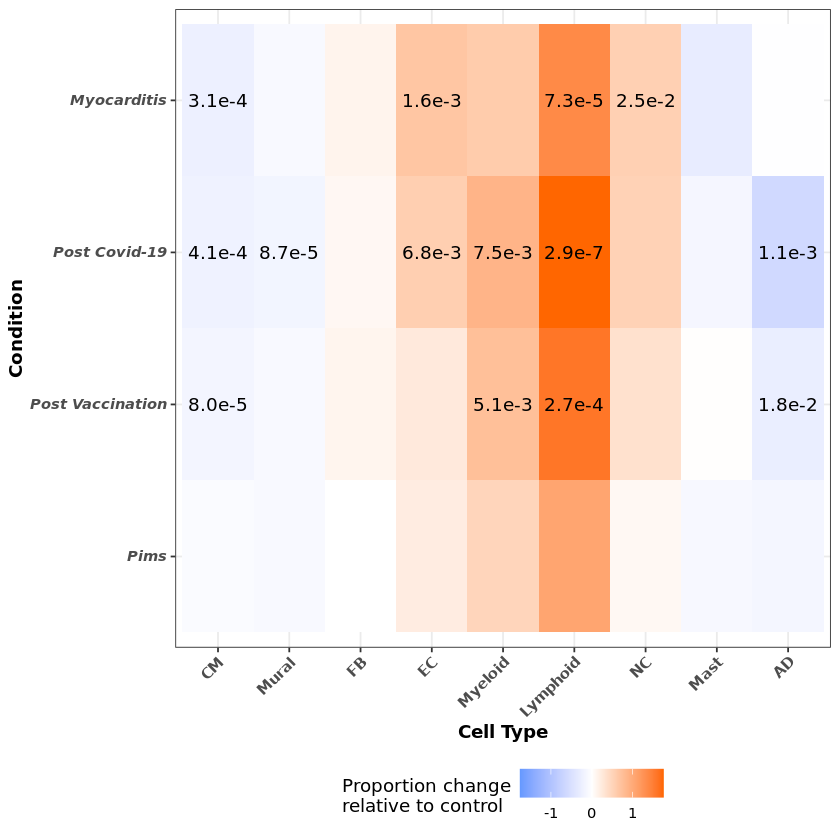

In [118]:
p1

In [119]:
p2 <- ggplot(aes(x=cellstate, y=mean.prop.ctrl*100, fill=cellstate), data=prop_ctrl) + geom_bar(stat="identity") + scale_fill_manual(values=cs_colmap) +
      geom_text(aes(y=mean.prop.ctrl * 100 + max(mean.prop.ctrl) * 4, label=signif(mean.prop.ctrl * 100, 2))) + labs(title=paste(""), y="Mean % in controls")  + no.xaxis + theme(legend.position = "none") + scale_x_discrete(drop=FALSE) + theme(axis.text.y=element_text(face="bold"), axis.title.y=element_text(face="bold"))

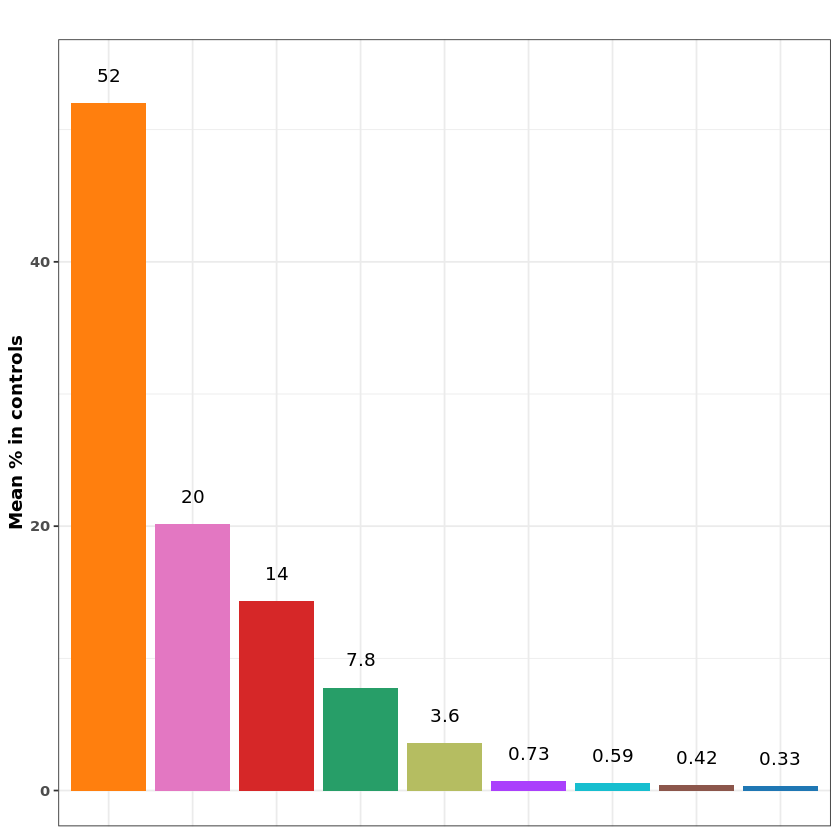

In [120]:
p2

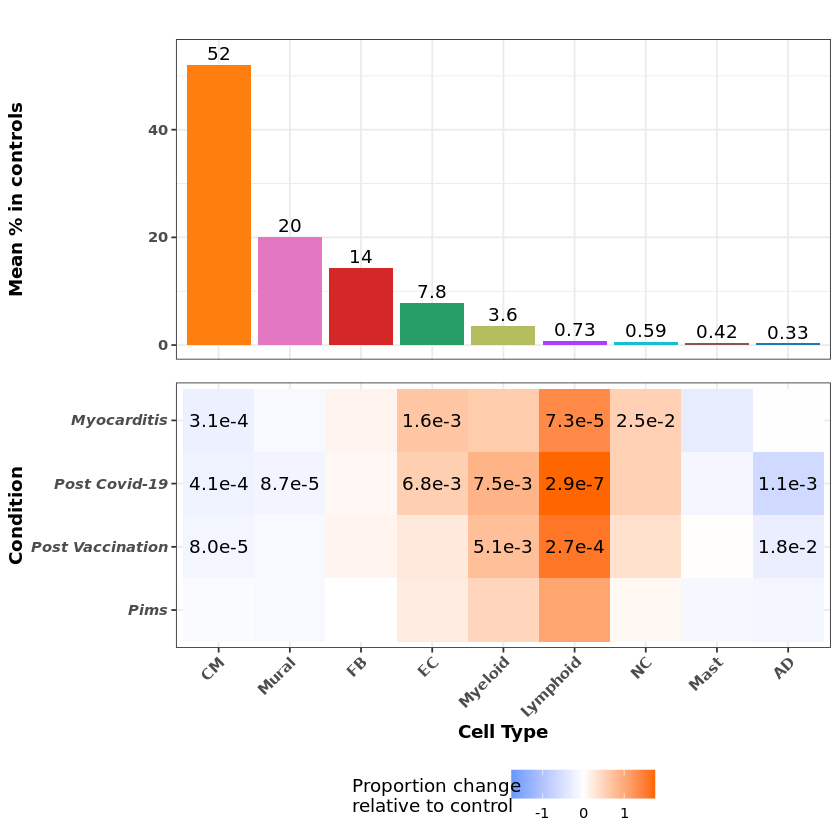

In [121]:
plot_all <- ggarrange(p2, p1, ncol=1, nrow=2, align="v", heights = c(4, 5))
plot_all

# Abundance plot Lymphoid

In [269]:
meta_lymph <- read.csv("Lymph_OBS.csv")

In [271]:
meta <- meta_lymph[,c("X", "Condition_custom", "leiden_annotated", 'Patient', 'Region')]
colnames(meta)[3] <- "cell_states"
meta[,"celltype_classified"] <- "Lymphoid"

In [273]:
meta$celltype_classified <- gsub("\\+ ", "_", meta$celltype_classified)
meta$cell_states <- gsub("\\+ ", "_", meta$cell_states)
meta <- meta[which(as.character(meta$Condition_custom)!="Pims follow up"),]
meta <- meta[which(as.character(meta$celltype_classified)!="unassigned"),]
meta$Condition_custom <- as.factor(as.character(meta$Condition_custom))

In [274]:
meta <- meta[-grep("LY[1|2|3]", meta$cell_states),]

In [275]:
META_CT <- meta

In [276]:
meta <- META_CT[META_CT$celltype_classified=="Lymphoid",]

In [279]:
meta <- meta[,c("Condition_custom", "Patient", 'cell_states')]
meta$Patient <- as.character(meta$Patient)
meta$Condition_custom <- as.character(meta$Condition_custom)
meta$cell_states <- as.character(meta$cell_states)
colnames(meta)[3] <- "leiden_annotated"

# Themes ggplot

In [281]:
theme_set(theme_bw())
flipx <- theme(axis.text.x=element_text(angle=90, hjust=1))
flipx45 <- theme(axis.text.x=element_text(angle=45, hjust=1))
no.xaxis <- theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank())
erics_theme <- theme(axis.text.x = element_text(color = "black", size = 13, angle = 90, hjust = 1, vjust = 1, face = "bold"),
                     axis.text.y = element_text(color = "black", size = 13, angle = 0, hjust = 0, vjust = 0, face = "bold"),
                     axis.title.x = element_text(color = "black", size = 20, angle = 0, hjust = .5, vjust = 0, face = "bold"),
                     axis.title.y = element_text(color = "black", size = 20, angle = 90, hjust = .5, vjust = .5, face = "bold"),
                     legend.text = element_text(size=15, face = "bold"),
                     legend.title = element_text(size=15, face = "bold"),
                     strip.text.x = element_text(size=13, face = "bold")
                     )
axis_format <- theme(axis.text.x = element_text(face = "bold"), axis.text.y = element_text(face = "bold"), axis.title.x = element_text(face = "bold"), axis.title.y = element_text(face = "bold"))
axis_format_bi <- theme(axis.text.x = element_text(face = "bold.italic"), axis.text.y = element_text(face = "bold.italic"), axis.title.x = element_text(face = "bold"), axis.title.y = element_text(face = "bold"))                                     

In [283]:
cs_colmap <- c(
'B' = '#1f77b4',
'CD4T_RORC+' = '#ff7f0e',
'CD4T_em1' = '#279e68',
'CD4T_em2' = '#d62728',
'CD4T_naive' = '#aa40fc',
'CD4T_reg' = '#8c564b',
'CD8T_GNLY_effector' = '#e377c2',
'CD8T_act_effector' = '#b5bd61',
'CD8T_em1' = '#17becf',
'CD8T_em2' = '#aec7e8',
'CD8T_em3' = '#ffbb78',
'LY1.unclassified' = '#98df8a',
'LY2.unclassified' = '#ff9896',
'NKT' = '#c5b0d5',
'NK_CD16hi' = '#c49c94',
'NK_CD16hiIFNGhi' = '#f7b6d2',
'NK_CD56hi' = '#dbdb8d',
'Plasma' = '#9edae5',
'T_prolif' = '#ad494a'
)


In [284]:
unique(meta$leiden_annotated)

[1] "CD8T_em1"           "NK_CD56hi"          "CD8T_em2"          
 [4] "CD8T_em3"           "CD4T_em2"           "CD4T_em1"          
 [7] "NK_CD16hi"          "CD4T_reg"           "CD4T_RORC+"        
[10] "CD8T_GNLY_effector" "NKT"                "Plasma"            
[13] "CD4T_naive"         "T_prolif"           "B"                 
[16] "NK_CD16hiIFNGhi"    "CD8T_act_effector"

In [285]:
our_fill_scale_gradient2 <- scale_fill_gradient2(limits=function(old) c(-max(abs(old)), max(abs(old))), high="#FF6600", mid = "white", low="#6699FF")

In [286]:
#meta <- meta[-which(meta$celltype_classified == 'unassigned'), ]
#meta

In [287]:
meta <- mutate(meta,condition=Condition_custom)


In [288]:
get.count.matrix <- function(props, celltype_col, value_col) {
  frm <- as.formula(paste("Patient", celltype_col, sep="~"))
  ct <- cast(props, frm, value=value_col, fun.aggregate=mean, add.missing=TRUE, na.rm=TRUE)
  ct[is.na(ct)] <- 0
  rownames(ct) <- ct$Patient
  dn <- list(rownames(ct), colnames(ct)[-1])
  ct <- as.matrix(ct[,-1]) 
  dimnames(ct) <- dn
  return(ct)
}

get.proportion.matrix <- function(prop.coarse, celltype_col, pseudocount=0, 
                                  value_col="proportion", impute_zeros=TRUE, 
                                  imputation_method="cmultRepl") {
  ct <- get.count.matrix(prop.coarse, celltype_col, value_col)
  if (!impute_zeros) {
    ct <- ct + pseudocount ## add pseudo count
    ct <- ct / rowSums(ct) ## renormalise
  } else {
    library(zCompositions)
    all_missing <- apply(is.na(ct), 1, all)
    if (imputation_method == "cmultRepl") {
      ct[!all_missing,] <- as.matrix(cmultRepl(ct[!all_missing,], method="GBM"))
    } else if (imputation_method == "multRepl") {
      dlim <- 1 / (prop.coarse %>% group_by(Patient) %>% dplyr::select(total) %>% slice_head(n=1) %>% deframe())
      ct[!all_missing,] <- as.matrix(multRepl(ct[!all_missing,], dl=dlim[rownames(ct)[!all_missing]]))
    }
  }
  return(ct)
}

In [289]:
da.by.covariate <- function(ct, celltype, column) {
  #select <- covar[[column]] %in% groups # & !all.zero
  Z <- clr(acomp(ct))
  data <- data.frame(abundance=Z[,celltype], proportion=ct[,celltype],"Condition_custom"=ct[,column])#[select,]
#   data$group <- factor(data[,column], levels=groups)
  m <- lm(as.formula(paste("abundance ~", column)), data=data)
  smr <- t(coef(summary(m))[2,])
  m2 <- lm(as.formula(paste("proportion ~", column)), data=data)
  smr2 <- t(coef(summary(m2))[2,])
  colnames(smr2) <- paste("prop",colnames(smr2), sep="_")
  ## two ways to normalize (either to overall mean)
  mean.prop <- mean(data$proportion)
  ## or to mean in controls
  mean.prop.ctrl <- coef(m2)[1]
  return(data.frame(smr, smr2, mean.prop, mean.prop.ctrl, check.names=FALSE))
}


In [290]:
prop.coarse <- meta %>% group_by(leiden_annotated, Patient, Condition_custom) %>% summarise(count=n())


`summarise()` has grouped output by 'leiden_annotated', 'Patient'. You can override using the `.groups` argument.



In [291]:
Eric_object <- get.proportion.matrix(prop.coarse,celltype_col = 'leiden_annotated',value_col = 'count')


No. corrected values:  143 


Make count matrix for filtering

In [292]:
count_matrix_all <- get.count.matrix(prop.coarse, celltype_col = 'leiden_annotated',value_col = 'count')
count_matrix_all <- as.data.frame(as.matrix(count_matrix_all))

In [293]:
Patient_condition <- meta[-which(duplicated(meta[,"Patient"])),c("Patient", 'Condition_custom')]  #table(meta$Patient, meta$Patient)

In [294]:
count_matrix_all <- merge(count_matrix_all, Patient_condition, by.x="row.names", by.y="Patient")
head(count_matrix_all)

,Row.names,B,CD4T_em1,CD4T_em2,CD4T_naive,CD4T_reg,CD4T_RORC+,CD8T_act_effector,CD8T_em1,CD8T_em2,CD8T_em3,CD8T_GNLY_effector,NK_CD16hi,NK_CD16hiIFNGhi,NK_CD56hi,NKT,Plasma,T_prolif,Condition_custom
,<I<chr>>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,BS_H15,2,20,12,6,7,2,0,50,46,16,20,6,1,26,2,1,2,Control
2,BS_H20,2,3,5,2,3,0,0,12,5,2,5,11,2,46,1,1,2,Control
3,BS_H25,1,3,0,0,2,1,0,5,7,1,7,3,0,7,1,1,2,Control
4,BS_H26,0,25,7,4,4,3,0,43,28,9,12,4,0,9,4,5,0,Control
5,BS_H35,0,4,4,0,1,1,0,10,31,13,2,2,0,40,0,1,0,Control
6,BS_H37,2,4,3,1,1,2,0,26,2,2,9,8,0,9,0,0,1,Control


In [296]:
count_matrix_condition <- apply(count_matrix_all[,2:18], 
                                2, 
                                function(i) 
                                       tapply(X = i, 
                                              INDEX = count_matrix_all$Condition_custom, 
                                              mean)
                                   )

In [297]:
count_matrix_all_melt <- reshape2::melt(count_matrix_all)
colnames(count_matrix_all_melt) <- c("Patient", "Condition_custom", "leiden_annotated", "nind.gene")
head(count_matrix_all_melt)

Using Row.names, Condition_custom as id variables



,Patient,Condition_custom,leiden_annotated,nind.gene
,<I<chr>>,<chr>,<fct>,<dbl>
1,BS_H15,Control,B,2
2,BS_H20,Control,B,2
3,BS_H25,Control,B,1
4,BS_H26,Control,B,0
5,BS_H35,Control,B,0
6,BS_H37,Control,B,2


In [298]:
count_matrix_condition_melt <- reshape2::melt(count_matrix_condition)
colnames(count_matrix_condition_melt) <- c("Condition_custom", "leiden_annotated", "mean_count")
head(count_matrix_condition_melt)

,Condition_custom,leiden_annotated,mean_count
,<fct>,<fct>,<dbl>
1,Control,B,1.111111
2,MIS-C,B,2.000000
3,Non-COVID-19,B,1.625000
4,Post-COVID-19,B,1.800000
5,Post-Vaccination,B,3.250000
6,Control,CD4T_em1,4.055556


Continue with values to plot

In [299]:
meta_ <- meta[-which(duplicated(meta$'Patient')),c('Patient','Condition_custom')]

In [300]:
Eric_object <- as.data.frame(as.matrix(Eric_object))


In [301]:
head(Eric_object)

,B,CD4T_em1,CD4T_em2,CD4T_naive,CD4T_reg,CD4T_RORC+,CD8T_act_effector,CD8T_em1,CD8T_em2,CD8T_em3,CD8T_GNLY_effector,NK_CD16hi,NK_CD16hiIFNGhi,NK_CD56hi,NKT,Plasma,T_prolif
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
BS_H15,0.009094474,0.09094474,0.054566845,0.027283423,0.031830660,0.009094474,0.004155075,0.22736185,0.20917291,0.07275579,0.09094474,0.02728342,0.004547237,0.11822816,0.009094474,0.004547237,0.009094474
BS_H20,0.019396553,0.02909483,0.048491383,0.019396553,0.029094830,0.002954545,0.007821251,0.11637932,0.04849138,0.01939655,0.04849138,0.10668104,0.019396553,0.44612072,0.009698277,0.009698277,0.019396553
BS_H25,0.023835990,0.07150797,0.005909091,0.005371901,0.047671980,0.023835990,0.007677165,0.11917995,0.16685193,0.02383599,0.16685193,0.07150797,0.003766263,0.16685193,0.023835990,0.023835990,0.047671980
BS_H26,0.002359055,0.15702599,0.043967277,0.025124158,0.025124158,0.018843119,0.005516027,0.27008470,0.17586911,0.05652936,0.07537247,0.02512416,0.001387680,0.05652936,0.025124158,0.031405198,0.004614035
BS_H35,0.003166444,0.03569246,0.035692461,0.007357326,0.008923115,0.008923115,0.007403891,0.08923115,0.27661658,0.11600050,0.01784623,0.01784623,0.001862614,0.35692461,0.001396961,0.008923115,0.006193192
BS_H37,0.028096671,0.05619334,0.042145007,0.014048336,0.014048336,0.028096671,0.010352684,0.36525673,0.02809667,0.02809667,0.12643502,0.11238668,0.002604449,0.12643502,0.001953337,0.001706037,0.014048336


In [302]:
merged_object <- merge(Eric_object,meta_,by.y = 'Patient',by.x = 'row.names',all = TRUE)


In [303]:
head(merged_object)

,Row.names,B,CD4T_em1,CD4T_em2,CD4T_naive,CD4T_reg,CD4T_RORC+,CD8T_act_effector,CD8T_em1,CD8T_em2,CD8T_em3,CD8T_GNLY_effector,NK_CD16hi,NK_CD16hiIFNGhi,NK_CD56hi,NKT,Plasma,T_prolif,Condition_custom
,<I<chr>>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,BS_H15,0.009094474,0.09094474,0.054566845,0.027283423,0.031830660,0.009094474,0.004155075,0.22736185,0.20917291,0.07275579,0.09094474,0.02728342,0.004547237,0.11822816,0.009094474,0.004547237,0.009094474,Control
2,BS_H20,0.019396553,0.02909483,0.048491383,0.019396553,0.029094830,0.002954545,0.007821251,0.11637932,0.04849138,0.01939655,0.04849138,0.10668104,0.019396553,0.44612072,0.009698277,0.009698277,0.019396553,Control
3,BS_H25,0.023835990,0.07150797,0.005909091,0.005371901,0.047671980,0.023835990,0.007677165,0.11917995,0.16685193,0.02383599,0.16685193,0.07150797,0.003766263,0.16685193,0.023835990,0.023835990,0.047671980,Control
4,BS_H26,0.002359055,0.15702599,0.043967277,0.025124158,0.025124158,0.018843119,0.005516027,0.27008470,0.17586911,0.05652936,0.07537247,0.02512416,0.001387680,0.05652936,0.025124158,0.031405198,0.004614035,Control
5,BS_H35,0.003166444,0.03569246,0.035692461,0.007357326,0.008923115,0.008923115,0.007403891,0.08923115,0.27661658,0.11600050,0.01784623,0.01784623,0.001862614,0.35692461,0.001396961,0.008923115,0.006193192,Control
6,BS_H37,0.028096671,0.05619334,0.042145007,0.014048336,0.014048336,0.028096671,0.010352684,0.36525673,0.02809667,0.02809667,0.12643502,0.11238668,0.002604449,0.12643502,0.001953337,0.001706037,0.014048336,Control


In [242]:
Conditions_loop <- unique(merged_object$Condition_custom)[-1]

all_results_out <- list()

for (CONDITION in Conditions_loop){
    selected <- merged_object[which(merged_object[,'Condition_custom'] %in% c('Control',CONDITION)),]
    # Filter out patients with low number of all nuclei (if applicable, only relevant for cell-state analysis)
    selected <- selected[which(selected$Row.names %in% count_matrix_all[which(apply(count_matrix_all[,2:18], 1, sum)>=30),"Row.names"]),]
    print(table(selected$Condition_custom))
    
    # Define cell-types/states
    cell_type <- colnames(merged_object)[3:length(colnames(merged_object))-1]
    
    suppressWarnings({    
    if (length(unique(selected$Condition_custom))>1 &
        all(table(as.character(selected$Condition_custom))>=2)) {
    sapply_out <- lapply(cell_type, function(i) da.by.covariate(selected,celltype = c(i),column = 'Condition_custom'))
    sapply_out <- do.call("rbind", sapply_out)
    rownames(sapply_out) <- cell_type
    all_results_out[[CONDITION]] <- sapply_out
                         }
        })
}




    Control Myocarditis 
         11           7 

      Control Post Covid-19 
           11            10 

Control    Pims 
     11       2 

         Control Post Vaccination 
              11                4 


In [243]:
all_results_out_pV <- do.call("rbind", lapply(all_results_out, function(i) i[,'Pr(>|t|)']))
                                               
all_results_out_meanprop <- do.call("rbind", lapply(all_results_out, function(i) i[,'mean.prop.ctrl']))                                               
all_results_out_Est <- do.call("rbind", lapply(all_results_out, function(i) i[,'mean.prop']))                                               
                                               
colnames(all_results_out_pV) <- colnames(merged_object)[3:length(colnames(merged_object))-1]

In [244]:
all_results_out_meanprop

Myocarditis,0.03217582,0.05779674,0.03613442,0.02021851,0.03094442,0.02550139,0.01750306,0.1686213,0.1398531,0.06036956,0.08034069,0.1167643,0.01735663,0.1497625,0.01020963,0.01458035,0.02186766
Post Covid-19,0.03217582,0.05779674,0.03613442,0.02021851,0.03094442,0.02550139,0.01750306,0.1686213,0.1398531,0.06036956,0.08034069,0.1167643,0.01735663,0.1497625,0.01020963,0.01458035,0.02186766
Pims,0.03217582,0.05779674,0.03613442,0.02021851,0.03094442,0.02550139,0.01750306,0.1686213,0.1398531,0.06036956,0.08034069,0.1167643,0.01735663,0.1497625,0.01020963,0.01458035,0.02186766
Post Vaccination,0.03217582,0.05779674,0.03613442,0.02021851,0.03094442,0.02550139,0.01750306,0.1686213,0.1398531,0.06036956,0.08034069,0.1167643,0.01735663,0.1497625,0.01020963,0.01458035,0.02186766


In [245]:
all_results_out_Est

Myocarditis,0.03029756,0.07799138,0.03921675,0.03830962,0.04565380,0.04045573,0.02964483,0.1288523,0.10212581,0.05939942,0.10194016,0.1495931,0.01632616,0.09848845,0.009779512,0.01207546,0.01984998
Post Covid-19,0.02363379,0.07211990,0.03927597,0.03223664,0.04797063,0.02407950,0.04583695,0.1329899,0.08319674,0.06257897,0.12146828,0.1699373,0.01292104,0.08963881,0.007072013,0.01503062,0.02001288
Pims,0.02871823,0.05574020,0.04956684,0.02093647,0.02884425,0.02426032,0.01805479,0.1486497,0.12251199,0.05581897,0.09971243,0.1310740,0.01706575,0.13107926,0.011926829,0.01644686,0.03959319
Post Vaccination,0.03049247,0.08929770,0.04032346,0.05456742,0.05428064,0.03935955,0.02311670,0.1402430,0.10753901,0.05634145,0.07266366,0.1109769,0.01438932,0.11977372,0.008341704,0.01316945,0.02512386


In [246]:
FC_all <- all_results_out_Est/all_results_out_meanprop
colnames(FC_all) <- colnames(merged_object)[3:length(colnames(merged_object))-1]

In [247]:
FC_all <- melt(FC_all)
colnames(FC_all) <- c("celltype", "Condition_custom", "change")

In [248]:
all_results_out_pV <- melt(all_results_out_pV)
colnames(all_results_out_pV) <- c("celltype", "Condition_custom", "pV")

In [249]:
colnames(all_results_out_pV)

[1] "celltype"         "Condition_custom" "pV"

In [250]:
y <- merge(all_results_out_pV, FC_all, by=c("celltype", "Condition_custom"))

In [251]:
colnames(y)[1:2] <- c("gene", "cellstate")

In [252]:
y$change <- log2(y$change)

Define order of cell-types and Conditions

In [253]:
y$gene <- factor(as.character(y$gene), levels=rev(c("Myocarditis", "Post Covid-19", "Post Vaccination", "Pims")))

In [254]:
prop_ctrl <- data.frame(cellstate=colnames(merged_object)[3:length(colnames(merged_object))-1],
                         mean.prop.ctrl=all_results_out_meanprop[1,]
                        )

In [255]:
y$cellstate <- factor(y$cellstate, levels=prop_ctrl$cellstate[order(prop_ctrl$mean.prop.ctrl, decreasing = T)])

In [256]:
prop_ctrl$cellstate <- factor(prop_ctrl$cellstate, levels=prop_ctrl$cellstate[order(prop_ctrl$mean.prop.ctrl, decreasing = T)])

In [258]:
tmp <- split(y, y$gene)#, function(i) i$FDR3 <- p.adjust(i$pV, method = "BH")))
y <- do.call("rbind", lapply(tmp, function(i) cbind(i, 'FDR_per_analysis'=p.adjust(i$pV, method = "BH"))))

In [260]:
y[y[,"gene"]=="Pims","FDR_per_analysis"] <- 1

In [261]:
y[which(abs(y$change)<=0.1),"FDR_per_analysis"] <- 1

In [262]:
p1 <- ggplot(aes(x=cellstate, y=gene, fill=change), data=y) + geom_tile() + our_fill_scale_gradient2 + flipx45 + 
      labs(y="Condition", x="Cell Type", fill="Proportion change\nrelative to control") + theme(legend.position = "bottom") + scale_x_discrete(drop=FALSE) + axis_format + theme(axis.text.y=element_text(face="bold.italic"))
sig <- with(y, FDR_per_analysis < 0.05)# & (mean.count.ctrl > 5 | mean.count.gene > 5) & nind.gene >= 0)
if (any(sig)) {
    p1 <- p1 + geom_text(aes(x=cellstate, y=gene, label=gsub("e-0", "e-", formatC(pV, format="e", digits=1))), data=y[sig,])
}

In [263]:
#prop_ctrl <- y %>% dplyr::select(cellstate, mean.prop.ctrl) %>% group_by(cellstate) %>% slice_head(n=1)
p2 <- ggplot(aes(x=cellstate, y=mean.prop.ctrl*100, fill=cellstate), data=prop_ctrl) + geom_bar(stat="identity") + scale_fill_manual(values=cs_colmap) +
      geom_text(aes(y=mean.prop.ctrl * 100 + max(mean.prop.ctrl) * 4, label=signif(mean.prop.ctrl * 100, 2))) + labs(title=paste(""), y="Mean % in controls")  + no.xaxis + theme(legend.position = "none") + scale_x_discrete(drop=FALSE) + theme(axis.text.y=element_text(face="bold"), axis.title.y=element_text(face="bold"))

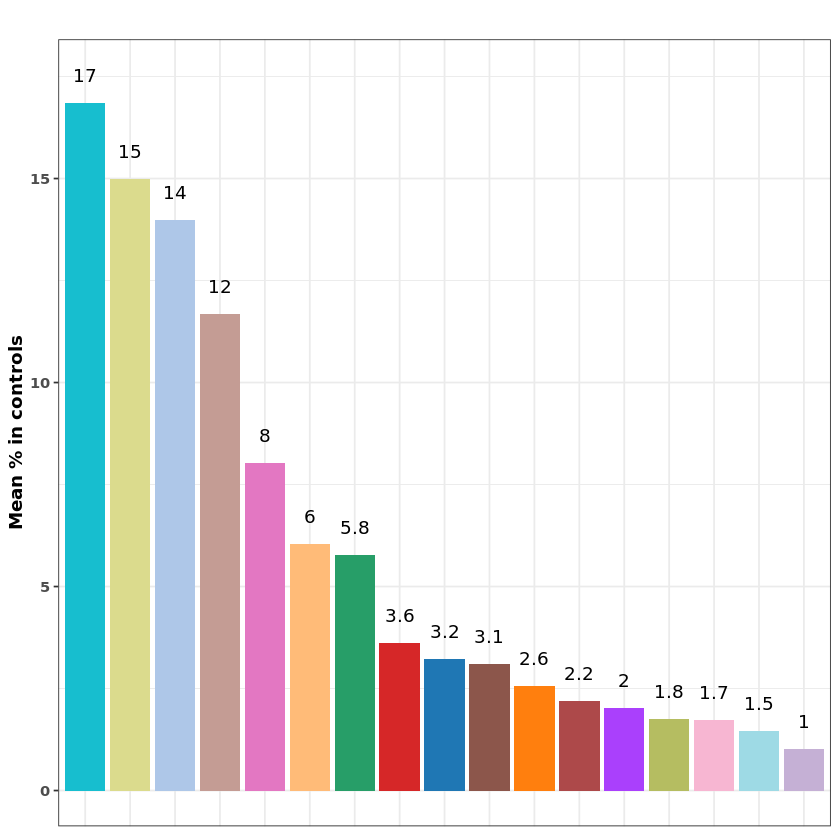

In [264]:
p2

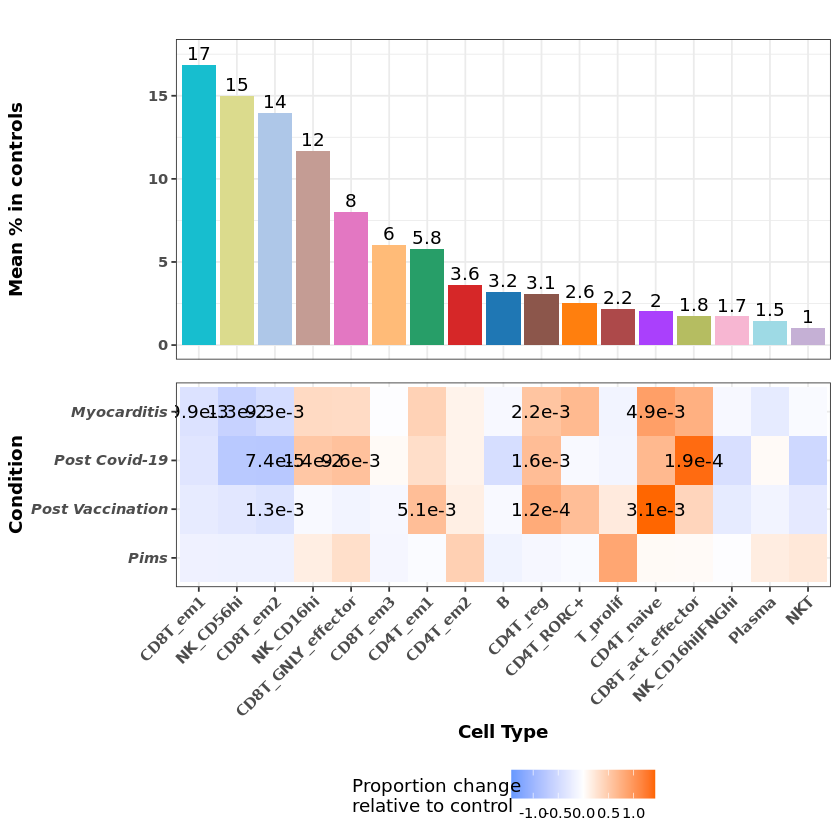

In [265]:
plot_all <- ggarrange(p2, p1, ncol=1, nrow=2, align="v", heights = c(4, 5))
plot_all

# Abundance plot Myeloid

In [341]:
meta <- read.csv("Myeloid_OBS.csv")

In [342]:
meta$celltype_classified <- gsub("\\+ ", "_", meta$celltype_classified)
meta <- meta[which(as.character(meta$Condition_custom)!="Pims follow up"),]
meta <- meta[which(as.character(meta$celltype_classified)!="unassigned"),]
meta$Condition_custom <- as.factor(as.character(meta$Condition_custom))

In [343]:
meta <- meta[-grep("MY[1|2|3]", meta$cell_states),]

In [344]:
META_CT <- meta

In [345]:
meta <- META_CT[META_CT$celltype_classified=="Myeloid",]

In [346]:
meta <- meta[,c("Condition_custom", "Patient", 'cell_states')]
meta$Patient <- as.character(meta$Patient)
meta$Condition_custom <- as.character(meta$Condition_custom)
meta$cell_states <- as.character(meta$cell_states)
colnames(meta)[3] <- "leiden_annotated"

# Themes ggplot

In [352]:
theme_set(theme_bw())
flipx <- theme(axis.text.x=element_text(angle=90, hjust=1))
flipx45 <- theme(axis.text.x=element_text(angle=45, hjust=1))
no.xaxis <- theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank())
erics_theme <- theme(axis.text.x = element_text(color = "black", size = 13, angle = 90, hjust = 1, vjust = 1, face = "bold"),
                     axis.text.y = element_text(color = "black", size = 13, angle = 0, hjust = 0, vjust = 0, face = "bold"),
                     axis.title.x = element_text(color = "black", size = 20, angle = 0, hjust = .5, vjust = 0, face = "bold"),
                     axis.title.y = element_text(color = "black", size = 20, angle = 90, hjust = .5, vjust = .5, face = "bold"),
                     legend.text = element_text(size=15, face = "bold"),
                     legend.title = element_text(size=15, face = "bold"),
                     strip.text.x = element_text(size=13, face = "bold")
                     )
axis_format <- theme(axis.text.x = element_text(face = "bold"), axis.text.y = element_text(face = "bold"), axis.title.x = element_text(face = "bold"), axis.title.y = element_text(face = "bold"))
axis_format_bi <- theme(axis.text.x = element_text(face = "bold.italic"), axis.text.y = element_text(face = "bold.italic"), axis.title.x = element_text(face = "bold"), axis.title.y = element_text(face = "bold"))                                     

In [353]:
cs_colmap <- c('MO_CD16+' = '#1f77b4',
'MO_VCAN+' = '#ff7f0e',
'MP_FOLR2' = '#279e68',
'MP_ISG' = '#d62728',
'MP_LYVE1hi/MHCII_intermediate' = '#aa40fc',
'MP_LYVE1hi/MHCII_lo' = '#8c564b',
'MP_LYVE1lo/MHCII_hi' = '#e377c2',
'MP_NFKB' = '#b5bd61',
'MP_OSM' = '#17becf',
'MP_TREM2+' = '#aec7e8',
'MP_prolif' = '#ffbb78',
'MP_prolif_DCN+' = '#98df8a',
'MY1.unclassified' = '#ff9896',
'MY2.unclassified' = '#c5b0d5',
'cDC1' = '#c49c94',
'cDC2' = '#f7b6d2')

In [355]:
our_fill_scale_gradient2 <- scale_fill_gradient2(limits=function(old) c(-max(abs(old)), max(abs(old))), high="#FF6600", mid = "white", low="#6699FF")

In [357]:
meta <- mutate(meta,condition=Condition_custom)


In [358]:
get.count.matrix <- function(props, celltype_col, value_col) {
  frm <- as.formula(paste("Patient", celltype_col, sep="~"))
  ct <- cast(props, frm, value=value_col, fun.aggregate=mean, add.missing=TRUE, na.rm=TRUE)
  ct[is.na(ct)] <- 0
  rownames(ct) <- ct$Patient
  dn <- list(rownames(ct), colnames(ct)[-1])
  ct <- as.matrix(ct[,-1]) 
  dimnames(ct) <- dn
  return(ct)
}

get.proportion.matrix <- function(prop.coarse, celltype_col, pseudocount=0, value_col="proportion", impute_zeros=TRUE, imputation_method="cmultRepl") {
  ct <- get.count.matrix(prop.coarse, celltype_col, value_col)
  if (!impute_zeros) {
    ct <- ct + pseudocount ## add pseudo count
    ct <- ct / rowSums(ct) ## renormalise
  } else {
    library(zCompositions)
    all_missing <- apply(is.na(ct), 1, all)
    if (imputation_method == "cmultRepl") {
      ct[!all_missing,] <- as.matrix(cmultRepl(ct[!all_missing,], method="GBM"))
    } else if (imputation_method == "multRepl") {
      dlim <- 1 / (prop.coarse %>% group_by(Patient) %>% dplyr::select(total) %>% slice_head(n=1) %>% deframe())
      ct[!all_missing,] <- as.matrix(multRepl(ct[!all_missing,], dl=dlim[rownames(ct)[!all_missing]]))
    }
  }
  return(ct)
}

In [359]:
da.by.covariate <- function(ct, celltype, column) {
  #select <- covar[[column]] %in% groups # & !all.zero
  Z <- clr(acomp(ct))
  data <- data.frame(abundance=Z[,celltype], proportion=ct[,celltype],"Condition_custom"=ct[,column])#[select,]
#   data$group <- factor(data[,column], levels=groups)
  m <- lm(as.formula(paste("abundance ~", column)), data=data)
  smr <- t(coef(summary(m))[2,])
  m2 <- lm(as.formula(paste("proportion ~", column)), data=data)
  smr2 <- t(coef(summary(m2))[2,])
  colnames(smr2) <- paste("prop",colnames(smr2), sep="_")
  ## two ways to normalize (either to overall mean)
  mean.prop <- mean(data$proportion)
  ## or to mean in controls
  mean.prop.ctrl <- coef(m2)[1]
  return(data.frame(smr, smr2, mean.prop, mean.prop.ctrl, check.names=FALSE))
}


In [360]:
prop.coarse <- meta %>% group_by(leiden_annotated, Patient, Condition_custom) %>% summarise(count=n())



`summarise()` has grouped output by 'leiden_annotated', 'Patient'. You can override using the `.groups` argument.



In [361]:
Eric_object <- get.proportion.matrix(prop.coarse,celltype_col = 'leiden_annotated',value_col = 'count')

No. corrected values:  83 


Make count matrix for filtering

In [362]:
count_matrix_all <- get.count.matrix(prop.coarse, celltype_col = 'leiden_annotated',value_col = 'count')
count_matrix_all <- as.data.frame(as.matrix(count_matrix_all))

In [363]:
Patient_condition <- meta[-which(duplicated(meta[,"Patient"])),c("Patient", 'Condition_custom')]  #table(meta$Patient, meta$Patient)

In [364]:
count_matrix_all <- merge(count_matrix_all, Patient_condition, by.x="row.names", by.y="Patient")
head(count_matrix_all)

,Row.names,cDC1,cDC2,MO_CD16+,MO_VCAN+,MP_FOLR2,MP_ISG,MP_LYVE1hi/MHCII_intermediate,MP_LYVE1hi/MHCII_lo,MP_LYVE1lo/MHCII_hi,MP_NFKB,MP_OSM,MP_prolif,MP_prolif_DCN+,MP_TREM2+,Condition_custom
,<I<chr>>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,BS_H15,0,2,0,7,4,1,8,30,36,1,10,10,3,4,Control
2,BS_H20,2,2,0,5,2,0,1,43,35,3,5,4,9,12,Control
3,BS_H25,1,1,0,1,4,1,3,36,55,0,3,10,4,7,Control
4,BS_H26,0,3,3,8,5,0,3,70,75,1,18,49,5,11,Control
5,BS_H35,3,5,1,3,8,1,10,124,65,2,39,25,7,5,Control
6,BS_H37,3,4,0,0,7,0,3,63,69,1,3,24,1,3,Control


In [365]:
count_matrix_condition <- apply(count_matrix_all[,2:15], 
                                2, 
                                function(i) 
                                       tapply(X = i, 
                                              INDEX = count_matrix_all$Condition_custom, 
                                              mean)
                                   )

In [366]:
count_matrix_all_melt <- reshape2::melt(count_matrix_all)
colnames(count_matrix_all_melt) <- c("Patient", "Condition_custom", "leiden_annotated", "nind.gene")
head(count_matrix_all_melt)

Using Row.names, Condition_custom as id variables



,Patient,Condition_custom,leiden_annotated,nind.gene
,<I<chr>>,<chr>,<fct>,<dbl>
1,BS_H15,Control,cDC1,0
2,BS_H20,Control,cDC1,2
3,BS_H25,Control,cDC1,1
4,BS_H26,Control,cDC1,0
5,BS_H35,Control,cDC1,3
6,BS_H37,Control,cDC1,3


In [367]:
count_matrix_condition_melt <- reshape2::melt(count_matrix_condition)
colnames(count_matrix_condition_melt) <- c("Condition_custom", "leiden_annotated", "mean_count")
head(count_matrix_condition_melt)

,Condition_custom,leiden_annotated,mean_count
,<fct>,<fct>,<dbl>
1,Control,cDC1,0.8888889
2,Myocarditis,cDC1,1.0000000
3,Pims,cDC1,4.0000000
4,Post Covid-19,cDC1,1.7000000
5,Post Vaccination,cDC1,4.0000000
6,Control,cDC2,6.0555556


Continue with values to plot

In [369]:
meta_ <- meta[-which(duplicated(meta$'Patient')),c('Patient','Condition_custom')]

In [370]:
Eric_object <- as.data.frame(as.matrix(Eric_object))


In [372]:
merged_object <- merge(Eric_object,meta_,by.y = 'Patient',by.x = 'row.names',all = TRUE)


In [373]:
head(merged_object)

,Row.names,cDC1,cDC2,MO_CD16+,MO_VCAN+,MP_FOLR2,MP_ISG,MP_LYVE1hi/MHCII_intermediate,MP_LYVE1hi/MHCII_lo,MP_LYVE1lo/MHCII_hi,MP_NFKB,MP_OSM,MP_prolif,MP_prolif_DCN+,MP_TREM2+,Condition_custom
,<I<chr>>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,BS_H15,0.0011689615,0.017193824,0.001589242,0.060178384,0.03438765,0.008596912,0.068775296,0.2579074,0.3094888,0.008596912,0.08596912,0.08596912,0.025790736,0.03438765,Control
2,BS_H20,0.0161960679,0.016196068,0.001589242,0.040490170,0.01619607,0.002352584,0.008098034,0.3482155,0.2834312,0.024294102,0.04049017,0.03239214,0.072882305,0.09717641,Control
3,BS_H25,0.0079033422,0.007903342,0.001589242,0.007903342,0.03161337,0.007903342,0.023710027,0.2845203,0.4346838,0.002589641,0.02371003,0.07903342,0.031613369,0.05532340,Control
4,BS_H26,0.0006064537,0.011929665,0.011929665,0.031812441,0.01988278,0.001278218,0.011929665,0.2783589,0.2982416,0.003976555,0.07157799,0.19485120,0.019882775,0.04374211,Control
5,BS_H35,0.0100671141,0.016778523,0.003355705,0.010067114,0.02684564,0.003355705,0.033557047,0.4161074,0.2181208,0.006711409,0.13087248,0.08389262,0.023489933,0.01677852,Control
6,BS_H37,0.0164596042,0.021946139,0.001589242,0.003651685,0.03840574,0.001696285,0.016459604,0.3456517,0.3785709,0.005486535,0.01645960,0.13167683,0.005486535,0.01645960,Control


In [254]:
Conditions_loop <- unique(merged_object$Condition_custom)[-1]

all_results_out <- list()

for (CONDITION in Conditions_loop){
    selected <- merged_object[which(merged_object[,'Condition_custom'] %in% c('Control',CONDITION)),]
    # Filter out patients with low number of all nuclei (if applicable, only relevant for cell-state analysis)
    selected <- selected[which(selected$Row.names %in% count_matrix_all[which(apply(count_matrix_all[,2:15], 1, sum)>=10),"Row.names"]),]
    print(table(selected$Condition_custom))
    
    # Define cell-types/states
    cell_type <- colnames(merged_object)[3:length(colnames(merged_object))-1]
    
    suppressWarnings({    
    if (length(unique(selected$Condition_custom))>1 &
        all(table(as.character(selected$Condition_custom))>=2)) {
    sapply_out <- lapply(cell_type, function(i) da.by.covariate(selected,celltype = c(i),column = 'Condition_custom'))
    sapply_out <- do.call("rbind", sapply_out)
    rownames(sapply_out) <- cell_type
    all_results_out[[CONDITION]] <- sapply_out
                         }
        })
}



    Control Myocarditis 
         18           8 

      Control Post Covid-19 
           18            10 

Control    Pims 
     18       2 

         Control Post Vaccination 
              18                4 


In [255]:
all_results_out_pV <- do.call("rbind", lapply(all_results_out, function(i) i[,'Pr(>|t|)']))
                                               
all_results_out_meanprop <- do.call("rbind", lapply(all_results_out, function(i) i[,'mean.prop.ctrl']))                                               
all_results_out_Est <- do.call("rbind", lapply(all_results_out, function(i) i[,'mean.prop']))                                               
                                               
colnames(all_results_out_pV) <- colnames(merged_object)[3:length(colnames(merged_object))-1]

In [258]:
FC_all <- all_results_out_Est/all_results_out_meanprop
colnames(FC_all) <- colnames(merged_object)[3:length(colnames(merged_object))-1]

In [259]:
FC_all <- melt(FC_all)
colnames(FC_all) <- c("celltype", "Condition_custom", "change")

In [260]:
all_results_out_pV <- melt(all_results_out_pV)
colnames(all_results_out_pV) <- c("celltype", "Condition_custom", "pV")

In [261]:
colnames(all_results_out_pV)

[1] "celltype"         "Condition_custom" "pV"

In [262]:
y <- merge(all_results_out_pV, FC_all, by=c("celltype", "Condition_custom"))

In [263]:
colnames(y)[1:2] <- c("gene", "cellstate")

In [264]:
y$change <- log2(y$change)

Define order of cell-types and Conditions

In [265]:
y$gene <- factor(as.character(y$gene), levels=rev(c("Myocarditis", "Post Covid-19", "Post Vaccination", "Pims")))

In [266]:
prop_ctrl <- data.frame(cellstate=colnames(merged_object)[3:length(colnames(merged_object))-1],
                         mean.prop.ctrl=all_results_out_meanprop[1,]
                        )

In [267]:
y$cellstate <- factor(y$cellstate, levels=prop_ctrl$cellstate[order(prop_ctrl$mean.prop.ctrl, decreasing = T)])

In [268]:
prop_ctrl$cellstate <- factor(prop_ctrl$cellstate, levels=prop_ctrl$cellstate[order(prop_ctrl$mean.prop.ctrl, decreasing = T)])

In [269]:
tmp <- split(y, y$gene)
y <- do.call("rbind", lapply(tmp, function(i) cbind(i, 'FDR_per_analysis'=p.adjust(i$pV, method = "BH"))))

In [270]:
y[y$gene=="Pims","FDR_per_analysis"] <- 1

In [271]:
y[which(abs(y$change)<=0.1),"FDR_per_analysis"] <- 1

In [273]:
p1 <- ggplot(aes(x=cellstate, y=gene, fill=change), data=y) + geom_tile() + our_fill_scale_gradient2 + flipx45 + 
      labs(y="Condition", x="Cell Type", fill="Proportion change\nrelative to control") + theme(legend.position = "bottom") + scale_x_discrete(drop=FALSE) + axis_format + theme(axis.text.y=element_text(face="bold.italic"))
sig <- with(y, FDR_per_analysis < 0.05)# & (mean.count.ctrl > 5 | mean.count.gene > 5) & nind.gene >= 0)
if (any(sig)) {
    p1 <- p1 + geom_text(aes(x=cellstate, y=gene, label=gsub("e-0", "e-", formatC(pV, format="e", digits=1))), data=y[sig,])
}

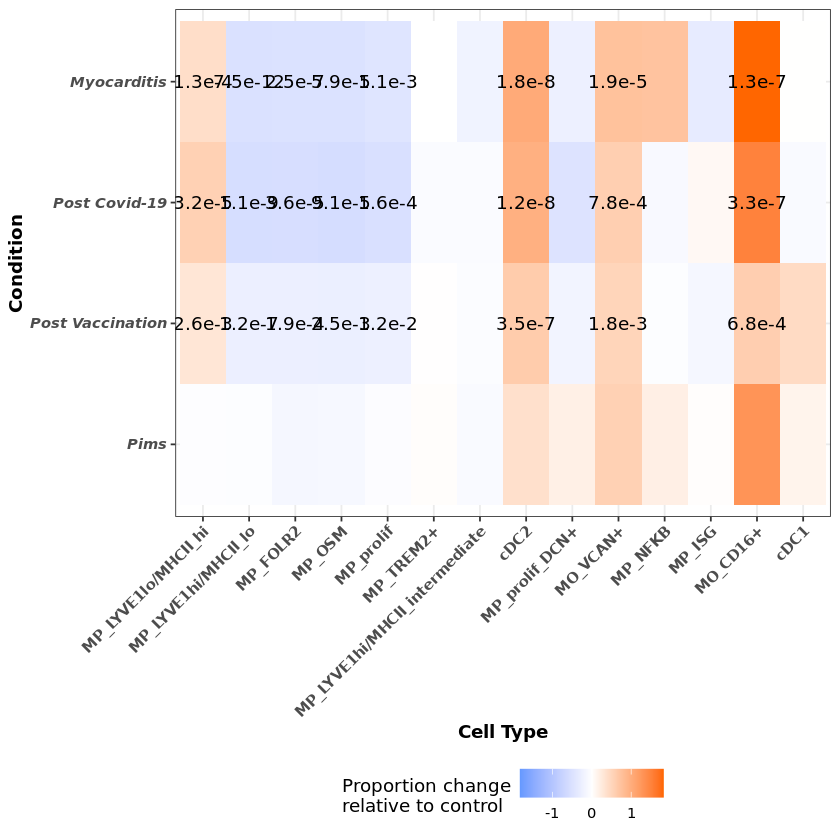

In [274]:
p1

In [275]:
p2 <- ggplot(aes(x=cellstate, y=mean.prop.ctrl*100, fill=cellstate), data=prop_ctrl) + geom_bar(stat="identity") + scale_fill_manual(values=cs_colmap) +
      geom_text(aes(y=mean.prop.ctrl * 100 + max(mean.prop.ctrl) * 4, label=signif(mean.prop.ctrl * 100, 2))) + labs(title=paste(""), y="Mean % in controls")  + no.xaxis + theme(legend.position = "none") + scale_x_discrete(drop=FALSE) + theme(axis.text.y=element_text(face="bold"), axis.title.y=element_text(face="bold"))

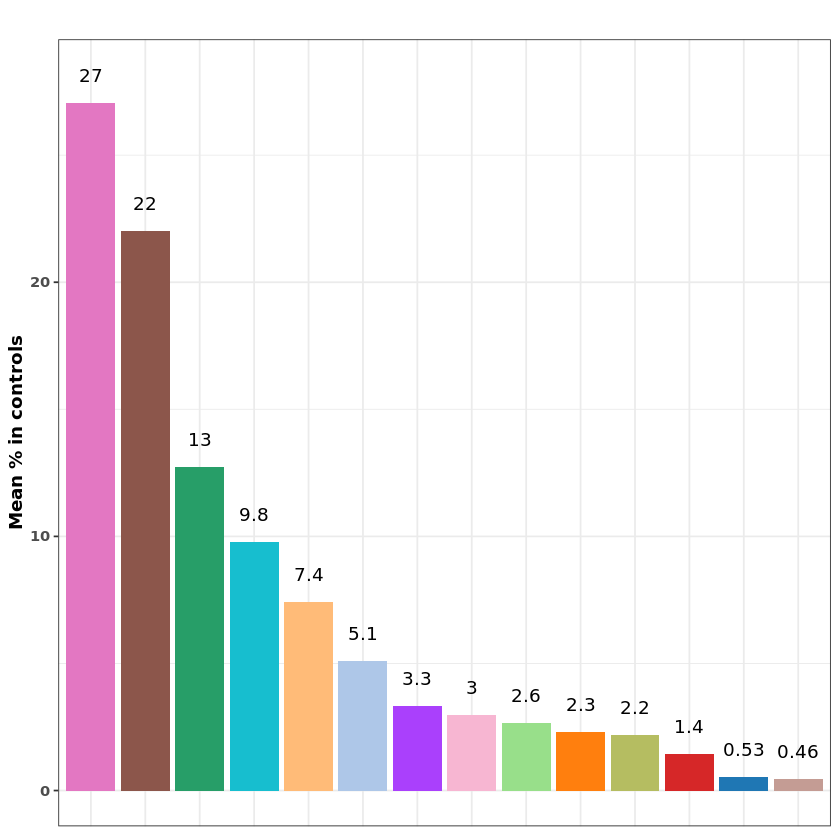

In [276]:
p2

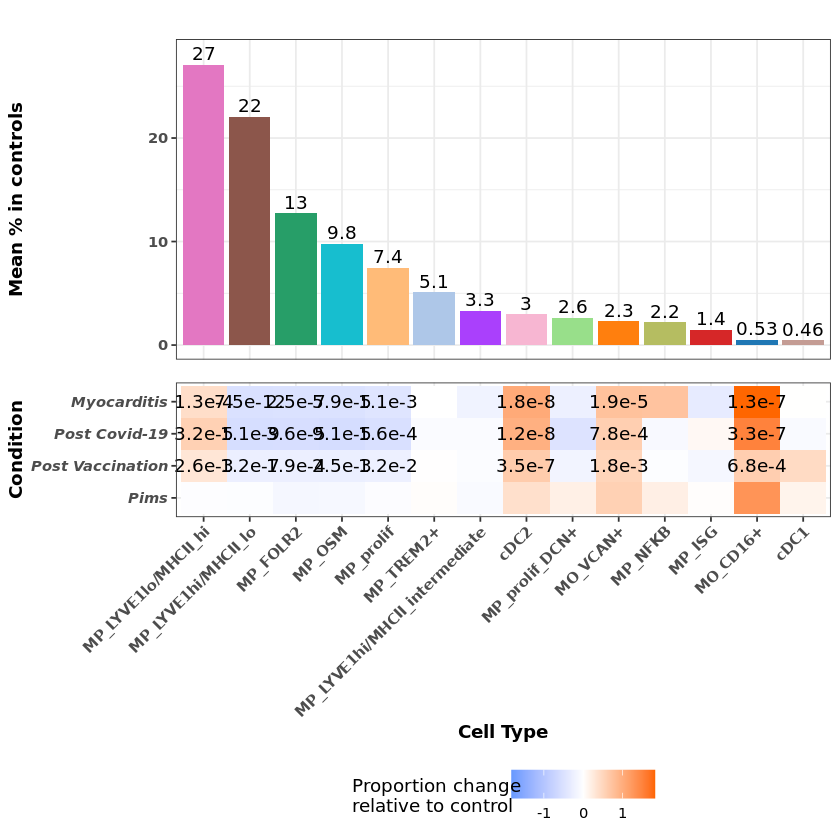

In [277]:
plot_all <- ggarrange(p2, p1, ncol=1, nrow=2, align="v", heights = c(4, 5))
plot_all

# Subclustering_vascular_cells

In [375]:
meta <- read.csv("/Vascular_OBS.csv")

In [376]:
meta$celltype_classified <- gsub("\\+ ", "_", meta$celltype_classified)
meta <- meta[which(as.character(meta$Condition_custom)!="Pims follow up"),]
meta <- meta[which(as.character(meta$celltype_classified)!="unassigned"),]
meta$Condition_custom <- as.factor(as.character(meta$Condition_custom))

In [377]:
META_CT <- meta

In [378]:
meta <- META_CT[META_CT$celltype_classified %in% c("Mural", "EC"),]

In [379]:
meta <- meta[,c("Condition_custom", "Patient", 'cell_states')]
meta$Patient <- as.character(meta$Patient)
meta$Condition_custom <- as.character(meta$Condition_custom)
meta$cell_states <- as.character(meta$cell_states)
colnames(meta)[3] <- "leiden_annotated"

In [380]:
unique(meta$leiden_annotated)

[1] "PC1"        "PC1.1"      "EC1"        "SMC1.1"     "EC5"       
 [6] "SMC1.2"     "PC3"        "PC2"        "EC6"        "EC_ISG"    
[11] "EC_disease"

In [381]:
meta$leiden_annotated <- gsub("EC_ISG", "EC9", meta$leiden_annotated)
meta$leiden_annotated <- gsub("EC_disease", "EC10", meta$leiden_annotated)

# Themes ggplot

In [385]:
theme_set(theme_bw())
flipx <- theme(axis.text.x=element_text(angle=90, hjust=1))
flipx45 <- theme(axis.text.x=element_text(angle=45, hjust=1))
no.xaxis <- theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank())
erics_theme <- theme(axis.text.x = element_text(color = "black", size = 13, angle = 90, hjust = 1, vjust = 1, face = "bold"),
                     axis.text.y = element_text(color = "black", size = 13, angle = 0, hjust = 0, vjust = 0, face = "bold"),
                     axis.title.x = element_text(color = "black", size = 20, angle = 0, hjust = .5, vjust = 0, face = "bold"),
                     axis.title.y = element_text(color = "black", size = 20, angle = 90, hjust = .5, vjust = .5, face = "bold"),
                     legend.text = element_text(size=15, face = "bold"),
                     legend.title = element_text(size=15, face = "bold"),
                     strip.text.x = element_text(size=13, face = "bold")
                     )
axis_format <- theme(axis.text.x = element_text(face = "bold"), axis.text.y = element_text(face = "bold"), axis.title.x = element_text(face = "bold"), axis.title.y = element_text(face = "bold"))
axis_format_bi <- theme(axis.text.x = element_text(face = "bold.italic"), axis.text.y = element_text(face = "bold.italic"), axis.title.x = element_text(face = "bold"), axis.title.y = element_text(face = "bold"))                                     

In [386]:
cs_colmap <- c(
'EC1' = '#1f77b4',
'EC5'= "#ff7f0e",
'EC6'= "#279e68",
'EC9'= "#d62728", # EC_ISG
'EC10'= "#aa40fc", # EC_disease
'PC1'= "#8c564b",
'PC1.1'= "#e377c2",
'PC2'= "#b5bd61",
'PC3'= "#17becf",
'SMC1.1'= "#aec7e8",
'SMC1.2'= "#ffbb78"
)

In [387]:
our_fill_scale_gradient2 <- scale_fill_gradient2(limits=function(old) c(-max(abs(old)), max(abs(old))), high="#FF6600", mid = "white", low="#6699FF")

In [389]:
meta <- mutate(meta,condition=Condition_custom)

In [390]:
get.count.matrix <- function(props, celltype_col, value_col) {
  frm <- as.formula(paste("Patient", celltype_col, sep="~"))
  ct <- cast(props, frm, value=value_col, fun.aggregate=mean, add.missing=TRUE, na.rm=TRUE)
  ct[is.na(ct)] <- 0
  rownames(ct) <- ct$Patient
  dn <- list(rownames(ct), colnames(ct)[-1])
  ct <- as.matrix(ct[,-1]) 
  dimnames(ct) <- dn
  return(ct)
}

get.proportion.matrix <- function(prop.coarse, celltype_col, pseudocount=0, value_col="proportion", impute_zeros=TRUE, imputation_method="cmultRepl") {
  ct <- get.count.matrix(prop.coarse, celltype_col, value_col)
  if (!impute_zeros) {
    ct <- ct + pseudocount ## add pseudo count
    ct <- ct / rowSums(ct) ## renormalise
  } else {
    library(zCompositions)
    all_missing <- apply(is.na(ct), 1, all)
    if (imputation_method == "cmultRepl") {
      ct[!all_missing,] <- as.matrix(cmultRepl(ct[!all_missing,], method="GBM"))
    } else if (imputation_method == "multRepl") {
      dlim <- 1 / (prop.coarse %>% group_by(Patient) %>% dplyr::select(total) %>% slice_head(n=1) %>% deframe())
      ct[!all_missing,] <- as.matrix(multRepl(ct[!all_missing,], dl=dlim[rownames(ct)[!all_missing]]))
    }
  }
  return(ct)
}

In [391]:
da.by.covariate <- function(ct, celltype, column) {
  #select <- covar[[column]] %in% groups # & !all.zero
  Z <- clr(acomp(ct))
  data <- data.frame(abundance=Z[,celltype], proportion=ct[,celltype],"Condition_custom"=ct[,column])#[select,]
#   data$group <- factor(data[,column], levels=groups)
  m <- lm(as.formula(paste("abundance ~", column)), data=data)
  smr <- t(coef(summary(m))[2,])
  m2 <- lm(as.formula(paste("proportion ~", column)), data=data)
  smr2 <- t(coef(summary(m2))[2,])
  colnames(smr2) <- paste("prop",colnames(smr2), sep="_")
  ## two ways to normalize (either to overall mean)
  mean.prop <- mean(data$proportion)
  ## or to mean in controls
  mean.prop.ctrl <- coef(m2)[1]
  return(data.frame(smr, smr2, mean.prop, mean.prop.ctrl, check.names=FALSE))
}


In [392]:
prop.coarse <- meta %>% group_by(leiden_annotated, Patient, Condition_custom) %>% summarise(count=n())



`summarise()` has grouped output by 'leiden_annotated', 'Patient'. You can override using the `.groups` argument.



In [393]:
Eric_object <- get.proportion.matrix(prop.coarse, celltype_col = 'leiden_annotated',
                                     value_col = 'count')

No. corrected values:  3 


Make count matrix for filtering

In [394]:
count_matrix_all <- get.count.matrix(prop.coarse, celltype_col = 'leiden_annotated',value_col = 'count')
count_matrix_all <- as.data.frame(as.matrix(count_matrix_all))

In [395]:
Patient_condition <- meta[-which(duplicated(meta[,"Patient"])),c("Patient", 'Condition_custom')]  #table(meta$Patient, meta$Patient)

In [396]:
count_matrix_all <- merge(count_matrix_all, Patient_condition, by.x="row.names", by.y="Patient")
head(count_matrix_all)

,Row.names,EC1,EC10,EC5,EC6,EC9,PC1,PC1.1,PC2,PC3,SMC1.1,SMC1.2,Condition_custom
,<I<chr>>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,BS_H15,737,0,193,67,13,2483,356,117,70,265,427,Control
2,BS_H20,382,1,82,24,6,1899,299,56,52,179,377,Control
3,BS_H25,618,2,89,48,12,2240,232,82,61,164,366,Control
4,BS_H26,1265,3,141,139,15,1852,259,119,40,196,332,Control
5,BS_H35,262,0,38,25,14,2127,378,64,54,163,353,Control
6,BS_H37,485,0,78,44,8,2981,350,80,89,221,647,Control


In [397]:
count_matrix_condition <- apply(count_matrix_all[,2:12], 
                                2, 
                                function(i) 
                                       tapply(X = i, 
                                              INDEX = count_matrix_all$Condition_custom, 
                                              mean)
                                   )

In [398]:
count_matrix_all_melt <- reshape2::melt(count_matrix_all)
colnames(count_matrix_all_melt) <- c("Patient", "Condition_custom", "leiden_annotated", "nind.gene")
head(count_matrix_all_melt)

Using Row.names, Condition_custom as id variables



,Patient,Condition_custom,leiden_annotated,nind.gene
,<I<chr>>,<chr>,<fct>,<dbl>
1,BS_H15,Control,EC1,737
2,BS_H20,Control,EC1,382
3,BS_H25,Control,EC1,618
4,BS_H26,Control,EC1,1265
5,BS_H35,Control,EC1,262
6,BS_H37,Control,EC1,485


In [399]:
count_matrix_condition_melt <- reshape2::melt(count_matrix_condition)
colnames(count_matrix_condition_melt) <- c("Condition_custom", "leiden_annotated", "mean_count")
head(count_matrix_condition_melt)

,Condition_custom,leiden_annotated,mean_count
,<fct>,<fct>,<dbl>
1,Control,EC1,391.8333333
2,Myocarditis,EC1,232.8750000
3,Pims,EC1,265.0000000
4,Post Covid-19,EC1,250.9000000
5,Post Vaccination,EC1,173.5000000
6,Control,EC10,0.5555556


Continue with values to plot

In [400]:
meta_ <- meta[-which(duplicated(meta$'Patient')),c('Patient','Condition_custom')]

In [401]:
Eric_object <- as.data.frame(as.matrix(Eric_object))


In [402]:
head(Eric_object)

,EC1,EC10,EC5,EC6,EC9,PC1,PC1.1,PC2,PC3,SMC1.1,SMC1.2
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
BS_H15,0.15587732,1.630229e-05,0.04081998,0.014170666,0.002749532,0.5251606,0.07529488,0.02474579,0.014805173,0.05604816,0.09031156
BS_H20,0.11379208,2.978850e-04,0.02442657,0.007149240,0.001787310,0.5656836,0.08906762,0.01668156,0.015490021,0.05332142,0.11230265
BS_H25,0.15789474,5.109862e-04,0.02273889,0.012263669,0.003065917,0.5723045,0.05927440,0.02095043,0.015585079,0.04190087,0.09351048
BS_H26,0.29007108,6.879156e-04,0.03233203,0.031873424,0.003439578,0.4246732,0.05939005,0.02728732,0.009172208,0.04494382,0.07612933
BS_H35,0.07532902,2.157996e-05,0.01092558,0.007187884,0.004025215,0.6115452,0.10868081,0.01840098,0.015525829,0.04686500,0.10149292
BS_H37,0.09732943,1.538831e-05,0.01565298,0.008829886,0.001605434,0.5982248,0.07023773,0.01605434,0.017860452,0.04435011,0.12983946


In [403]:
merged_object <- merge(Eric_object,meta_,by.y = 'Patient',by.x = 'row.names',all = TRUE)


In [406]:
Conditions_loop <- unique(merged_object$Condition_custom)[-1]

all_results_out <- list()

for (CONDITION in Conditions_loop){
    selected <- merged_object[which(merged_object[,'Condition_custom'] %in% c('Control',CONDITION)),]
    # Filter out patients with low number of all nuclei (if applicable, only relevant for cell-state analysis)
    selected <- selected[which(selected$Row.names %in% count_matrix_all[which(apply(count_matrix_all[,2:12], 1, sum)>=10),"Row.names"]),]
    print(table(selected$Condition_custom))
    
    # Define cell-types/states
    cell_type <- colnames(merged_object)[3:length(colnames(merged_object))-1]
    
    suppressWarnings({    
    if (length(unique(selected$Condition_custom))>1 &
        all(table(as.character(selected$Condition_custom))>=2)) {
    sapply_out <- lapply(cell_type, function(i) da.by.covariate(selected,celltype = c(i),column = 'Condition_custom'))
    sapply_out <- do.call("rbind", sapply_out)
    rownames(sapply_out) <- cell_type
    all_results_out[[CONDITION]] <- sapply_out
                         }
        })
}
                    


    Control Myocarditis 
         18           8 

      Control Post Covid-19 
           18            10 

Control    Pims 
     18       2 

         Control Post Vaccination 
              18                4 


In [407]:
all_results_out_pV <- do.call("rbind", lapply(all_results_out, function(i) i[,'Pr(>|t|)']))
                                               
all_results_out_meanprop <- do.call("rbind", lapply(all_results_out, function(i) i[,'mean.prop.ctrl']))                                               
all_results_out_Est <- do.call("rbind", lapply(all_results_out, function(i) i[,'mean.prop']))                                               
                                               
colnames(all_results_out_pV) <- colnames(merged_object)[3:length(colnames(merged_object))-1]

In [408]:
all_results_out_meanprop

Myocarditis,0.1973351,0.0003016678,0.03555791,0.03565245,0.02562207,0.4628337,0.073607,0.01382696,0.06506984,0.02641072,0.06378255
Post Covid-19,0.1973351,0.0003016678,0.03555791,0.03565245,0.02562207,0.4628337,0.073607,0.01382696,0.06506984,0.02641072,0.06378255
Pims,0.1973351,0.0003016678,0.03555791,0.03565245,0.02562207,0.4628337,0.073607,0.01382696,0.06506984,0.02641072,0.06378255
Post Vaccination,0.1973351,0.0003016678,0.03555791,0.03565245,0.02562207,0.4628337,0.073607,0.01382696,0.06506984,0.02641072,0.06378255


In [409]:
all_results_out_Est

Myocarditis,0.2392148,0.0056385010,0.07127866,0.04080783,0.02608115,0.4027886,0.05381033,0.01344626,0.05835738,0.02683618,0.06174037
Post Covid-19,0.2411786,0.0033612268,0.07373006,0.03927146,0.03268061,0.3963042,0.05153500,0.01180255,0.06111121,0.02709364,0.06193152
Pims,0.2171014,0.0002820034,0.05231810,0.04261794,0.02478323,0.4359972,0.06700248,0.01372517,0.06088298,0.02527690,0.06001258
Post Vaccination,0.2164954,0.0021614903,0.05249953,0.04433824,0.02461408,0.4373251,0.06225723,0.01294918,0.05978991,0.02526143,0.06230842


In [410]:
FC_all <- all_results_out_Est/all_results_out_meanprop
colnames(FC_all) <- colnames(merged_object)[3:length(colnames(merged_object))-1]

In [411]:
FC_all <- melt(FC_all)
colnames(FC_all) <- c("celltype", "Condition_custom", "change")

In [412]:
all_results_out_pV <- melt(all_results_out_pV)
colnames(all_results_out_pV) <- c("celltype", "Condition_custom", "pV")

In [413]:
colnames(all_results_out_pV)

[1] "celltype"         "Condition_custom" "pV"

In [414]:
y <- merge(all_results_out_pV, FC_all, by=c("celltype", "Condition_custom"))

In [415]:
colnames(y)[1:2] <- c("gene", "cellstate")

In [416]:
y$change <- log2(y$change)

Define order of cell-types and Conditions

In [417]:
y$gene <- factor(as.character(y$gene), levels=rev(c("Myocarditis", "Post Covid-19", "Post Vaccination", "Pims")))

In [418]:
prop_ctrl <- data.frame(cellstate=colnames(merged_object)[3:length(colnames(merged_object))-1],
                         mean.prop.ctrl=all_results_out_meanprop[1,]
                        )

In [419]:
y$cellstate <- factor(y$cellstate, levels=prop_ctrl$cellstate[order(prop_ctrl$mean.prop.ctrl, decreasing = T)])

In [420]:
prop_ctrl$cellstate <- factor(prop_ctrl$cellstate, levels=prop_ctrl$cellstate[order(prop_ctrl$mean.prop.ctrl, decreasing = T)])

In [421]:
tmp <- split(y, y$gene)#, function(i) i$FDR3 <- p.adjust(i$pV, method = "BH")))
y <- do.call("rbind", lapply(tmp, function(i) cbind(i, 'FDR_per_analysis'=p.adjust(i$pV, method = "BH"))))

In [422]:
y[y$gene=="Pims","FDR_per_analysis"] <- 1

In [423]:
y[which(abs(y$change)<=0.1),"FDR_per_analysis"] <- 1

In [425]:
p1 <- ggplot(aes(x=cellstate, y=gene, fill=change), data=y) + geom_tile() + our_fill_scale_gradient2 + flipx45 + 
      labs(y="Condition", x="Cell Type", fill="Proportion change\nrelative to control") + theme(legend.position = "bottom") + scale_x_discrete(drop=FALSE) + axis_format + theme(axis.text.y=element_text(face="bold.italic"))
sig <- with(y, FDR_per_analysis < 0.05)# & (mean.count.ctrl > 5 | mean.count.gene > 5) & nind.gene >= 0)
if (any(sig)) {
    p1 <- p1 + geom_text(aes(x=cellstate, y=gene, label=gsub("e-0", "e-", formatC(pV, format="e", digits=1))), data=y[sig,])
}

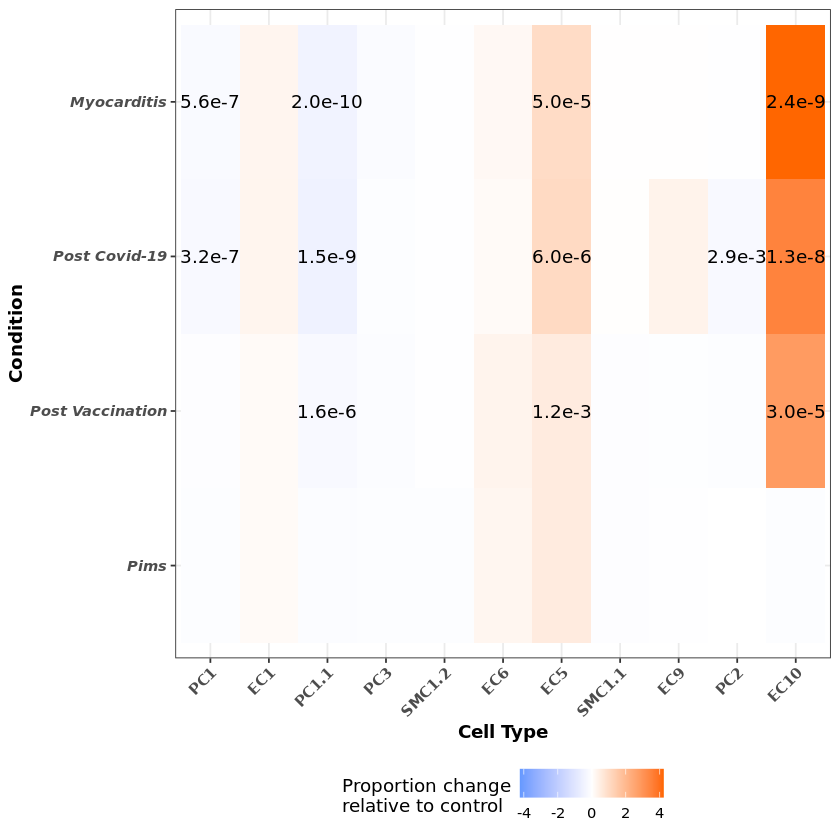

In [426]:
p1

In [427]:
p2 <- ggplot(aes(x=cellstate, y=mean.prop.ctrl*100, fill=cellstate), data=prop_ctrl) + geom_bar(stat="identity") + scale_fill_manual(values=cs_colmap) +
      geom_text(aes(y=mean.prop.ctrl * 100 + max(mean.prop.ctrl) * 4, label=signif(mean.prop.ctrl * 100, 2))) + labs(title=paste(""), y="Mean % in controls")  + no.xaxis + theme(legend.position = "none") + scale_x_discrete(drop=FALSE) + theme(axis.text.y=element_text(face="bold"), axis.title.y=element_text(face="bold"))

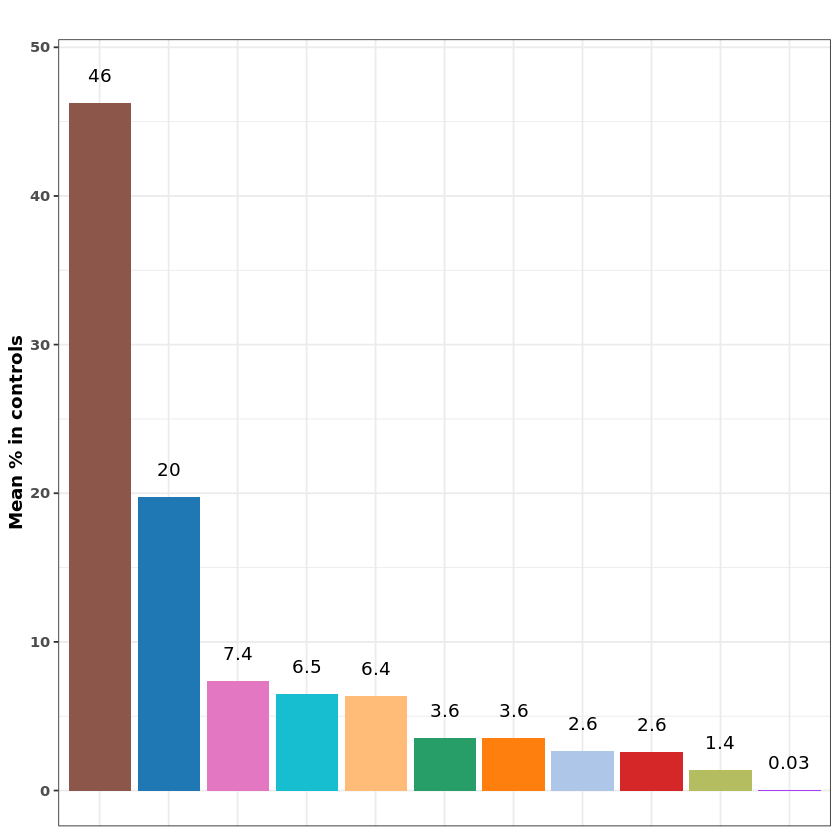

In [428]:
p2

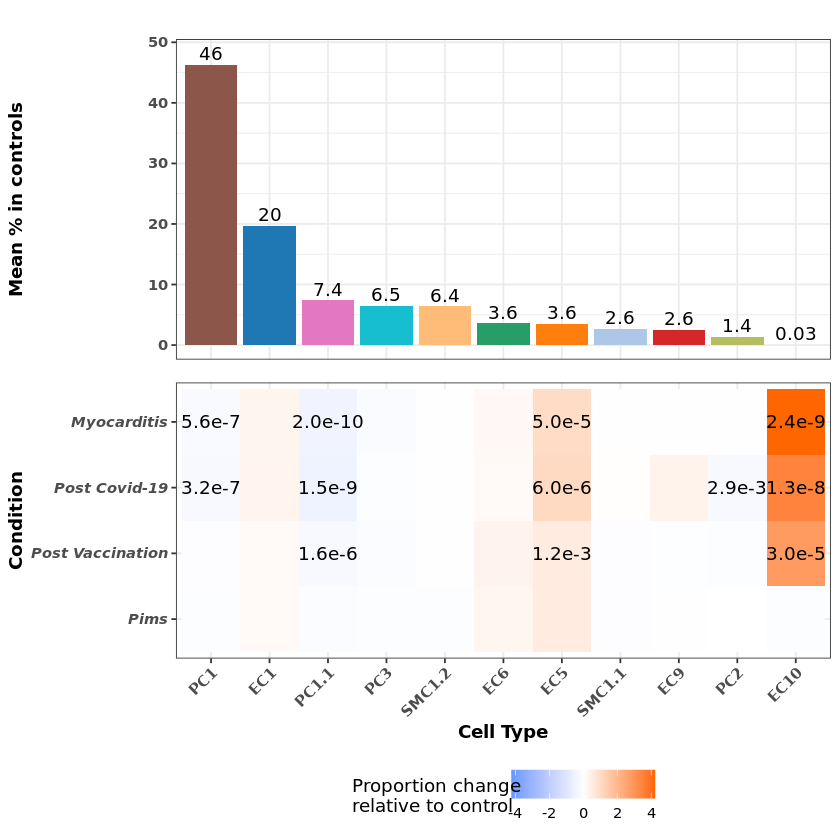

In [429]:
plot_all <- ggarrange(p2, p1, ncol=1, nrow=2, align="v", heights = c(4, 5))
plot_all

# Subclustering_FB

In [432]:
meta <- read.csv("/FB_META.csv")

In [433]:
meta$celltype_classified <- gsub("\\+ ", "_", meta$celltype_classified)
meta <- meta[which(as.character(meta$Condition_custom)!="Pims follow up"),]
meta <- meta[which(as.character(meta$celltype_classified)!="unassigned"),]
meta$Condition_custom <- as.factor(as.character(meta$Condition_custom))

In [434]:
META_CT <- meta

In [435]:
meta <- META_CT[META_CT$celltype_classified %in% c("FB"),]

In [436]:
meta <- meta[,c("Condition_custom", "Patient", 'cell_states')]
meta$Patient <- as.character(meta$Patient)
meta$Condition_custom <- as.character(meta$Condition_custom)
meta$cell_states <- as.character(meta$cell_states)
colnames(meta)[3] <- "leiden_annotated"

In [437]:
unique(meta$leiden_annotated)

[1] "vFB1.0"  "vFB4"    "vFB2"    "vFB1.2"  "vFB_ISG" "vFB3"    "vFB1.1"

In [438]:
meta$leiden_annotated <- gsub("vFB_ISG", "vFB5", meta$leiden_annotated)

# Themes ggplot

In [442]:
theme_set(theme_bw())
flipx <- theme(axis.text.x=element_text(angle=90, hjust=1))
flipx45 <- theme(axis.text.x=element_text(angle=45, hjust=1))
no.xaxis <- theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank())
erics_theme <- theme(axis.text.x = element_text(color = "black", size = 13, angle = 90, hjust = 1, vjust = 1, face = "bold"),
                     axis.text.y = element_text(color = "black", size = 13, angle = 0, hjust = 0, vjust = 0, face = "bold"),
                     axis.title.x = element_text(color = "black", size = 20, angle = 0, hjust = .5, vjust = 0, face = "bold"),
                     axis.title.y = element_text(color = "black", size = 20, angle = 90, hjust = .5, vjust = .5, face = "bold"),
                     legend.text = element_text(size=15, face = "bold"),
                     legend.title = element_text(size=15, face = "bold"),
                     strip.text.x = element_text(size=13, face = "bold")
                     )
axis_format <- theme(axis.text.x = element_text(face = "bold"), axis.text.y = element_text(face = "bold"), axis.title.x = element_text(face = "bold"), axis.title.y = element_text(face = "bold"))
axis_format_bi <- theme(axis.text.x = element_text(face = "bold.italic"), axis.text.y = element_text(face = "bold.italic"), axis.title.x = element_text(face = "bold"), axis.title.y = element_text(face = "bold"))                                     

In [443]:
cs_colmap <- c(
'vFB1.0'='#1f77b4',
'vFB1.1'='#279e68',
'vFB1.2'='#ff7f0e',
'vFB2'='#d62728',
'vFB3'='#aa40fc',
'vFB4'='#8c564b',
'vFB5'='#e377c2' # vFB_ISG
)

In [444]:
our_fill_scale_gradient2 <- scale_fill_gradient2(limits=function(old) c(-max(abs(old)), max(abs(old))), high="#FF6600", mid = "white", low="#6699FF")

In [446]:
meta <- mutate(meta,condition=Condition_custom)


In [447]:
get.count.matrix <- function(props, celltype_col, value_col) {
  frm <- as.formula(paste("Patient", celltype_col, sep="~"))
  ct <- cast(props, frm, value=value_col, fun.aggregate=mean, add.missing=TRUE, na.rm=TRUE)
  ct[is.na(ct)] <- 0
  rownames(ct) <- ct$Patient
  dn <- list(rownames(ct), colnames(ct)[-1])
  ct <- as.matrix(ct[,-1]) 
  dimnames(ct) <- dn
  return(ct)
}

get.proportion.matrix <- function(prop.coarse, celltype_col, pseudocount=0, value_col="proportion", impute_zeros=TRUE, imputation_method="cmultRepl") {
  ct <- get.count.matrix(prop.coarse, celltype_col, value_col)
  if (!impute_zeros) {
    ct <- ct + pseudocount ## add pseudo count
    ct <- ct / rowSums(ct) ## renormalise
  } else {
    library(zCompositions)
    all_missing <- apply(is.na(ct), 1, all)
    if (imputation_method == "cmultRepl") {
      ct[!all_missing,] <- as.matrix(cmultRepl(ct[!all_missing,], method="GBM"))
    } else if (imputation_method == "multRepl") {
      dlim <- 1 / (prop.coarse %>% group_by(Patient) %>% dplyr::select(total) %>% slice_head(n=1) %>% deframe())
      ct[!all_missing,] <- as.matrix(multRepl(ct[!all_missing,], dl=dlim[rownames(ct)[!all_missing]]))
    }
  }
  return(ct)
}

In [448]:
da.by.covariate <- function(ct, celltype, column) {
  #select <- covar[[column]] %in% groups # & !all.zero
  Z <- clr(acomp(ct))
  data <- data.frame(abundance=Z[,celltype], proportion=ct[,celltype],"Condition_custom"=ct[,column])#[select,]
#   data$group <- factor(data[,column], levels=groups)
  m <- lm(as.formula(paste("abundance ~", column)), data=data)
  smr <- t(coef(summary(m))[2,])
  m2 <- lm(as.formula(paste("proportion ~", column)), data=data)
  smr2 <- t(coef(summary(m2))[2,])
  colnames(smr2) <- paste("prop",colnames(smr2), sep="_")
  ## two ways to normalize (either to overall mean)
  mean.prop <- mean(data$proportion)
  ## or to mean in controls
  mean.prop.ctrl <- coef(m2)[1]
  return(data.frame(smr, smr2, mean.prop, mean.prop.ctrl, check.names=FALSE))
}


In [449]:
prop.coarse <- meta %>% group_by(leiden_annotated, Patient, Condition_custom) %>% summarise(count=n())



`summarise()` has grouped output by 'leiden_annotated', 'Patient'. You can override using the `.groups` argument.



In [450]:
Eric_object <- get.proportion.matrix(prop.coarse, celltype_col = 'leiden_annotated',
                                     value_col = 'count')

No. corrected values:  8 


Make count matrix for filtering

In [451]:
count_matrix_all <- get.count.matrix(prop.coarse, celltype_col = 'leiden_annotated',value_col = 'count')
count_matrix_all <- as.data.frame(as.matrix(count_matrix_all))

In [452]:
Patient_condition <- meta[-which(duplicated(meta[,"Patient"])),c("Patient", 'Condition_custom')]  #table(meta$Patient, meta$Patient)

In [453]:
count_matrix_all <- merge(count_matrix_all, Patient_condition, by.x="row.names", by.y="Patient")
head(count_matrix_all)

,Row.names,vFB1.0,vFB1.1,vFB1.2,vFB2,vFB3,vFB4,vFB5,Condition_custom
,<I<chr>>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,BS_H15,580,54,116,39,69,134,6,Control
2,BS_H20,467,46,101,107,32,61,2,Control
3,BS_H25,675,77,84,69,19,66,9,Control
4,BS_H26,461,7,94,46,34,33,3,Control
5,BS_H35,345,9,76,20,40,69,6,Control
6,BS_H37,282,20,32,35,9,41,3,Control


In [454]:
count_matrix_condition <- apply(count_matrix_all[,2:8], 
                                2, 
                                function(i) 
                                       tapply(X = i, 
                                              INDEX = count_matrix_all$Condition_custom, 
                                              mean)
                                   )

In [455]:
count_matrix_all_melt <- reshape2::melt(count_matrix_all)
colnames(count_matrix_all_melt) <- c("Patient", "Condition_custom", "leiden_annotated", "nind.gene")
head(count_matrix_all_melt)

Using Row.names, Condition_custom as id variables



,Patient,Condition_custom,leiden_annotated,nind.gene
,<I<chr>>,<chr>,<fct>,<dbl>
1,BS_H15,Control,vFB1.0,580
2,BS_H20,Control,vFB1.0,467
3,BS_H25,Control,vFB1.0,675
4,BS_H26,Control,vFB1.0,461
5,BS_H35,Control,vFB1.0,345
6,BS_H37,Control,vFB1.0,282


In [456]:
count_matrix_condition_melt <- reshape2::melt(count_matrix_condition)
colnames(count_matrix_condition_melt) <- c("Condition_custom", "leiden_annotated", "mean_count")
head(count_matrix_condition_melt)

,Condition_custom,leiden_annotated,mean_count
,<fct>,<fct>,<dbl>
1,Control,vFB1.0,414.1111
2,Myocarditis,vFB1.0,162.7500
3,Pims,vFB1.0,133.5000
4,Post Covid-19,vFB1.0,228.5000
5,Post Vaccination,vFB1.0,230.5000
6,Control,vFB1.1,206.8889


Continue with values to plot

In [457]:
meta_ <- meta[-which(duplicated(meta$'Patient')),c('Patient','Condition_custom')]

In [458]:
Eric_object <- as.data.frame(as.matrix(Eric_object))


In [460]:
merged_object <- merge(Eric_object,meta_,by.y = 'Patient',by.x = 'row.names',all = TRUE)


In [461]:
head(merged_object)

,Row.names,vFB1.0,vFB1.1,vFB1.2,vFB2,vFB3,vFB4,vFB5,Condition_custom
,<I<chr>>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,BS_H15,0.5811623,0.05410822,0.11623246,0.03907816,0.06913828,0.13426854,0.006012024,Control
2,BS_H20,0.5723039,0.05637255,0.12377451,0.13112745,0.03921569,0.07475490,0.002450980,Control
3,BS_H25,0.6756757,0.07707708,0.08408408,0.06906907,0.01901902,0.06606607,0.009009009,Control
4,BS_H26,0.6799410,0.01032448,0.13864307,0.06784661,0.05014749,0.04867257,0.004424779,Control
5,BS_H35,0.6106195,0.01592920,0.13451327,0.03539823,0.07079646,0.12212389,0.010619469,Control
6,BS_H37,0.6682464,0.04739336,0.07582938,0.08293839,0.02132701,0.09715640,0.007109005,Control


In [463]:
Conditions_loop <- unique(merged_object$Condition_custom)[-1]

all_results_out <- list()

for (CONDITION in Conditions_loop){
    selected <- merged_object[which(merged_object[,'Condition_custom'] %in% c('Control',CONDITION)),]
    # Filter out patients with low number of all nuclei (if applicable, only relevant for cell-state analysis)
    selected <- selected[which(selected$Row.names %in% count_matrix_all[which(apply(count_matrix_all[,2:8], 1, sum)>=10),"Row.names"]),]
    print(table(selected$Condition_custom))
    
    # Define cell-types/states
    cell_type <- colnames(merged_object)[3:length(colnames(merged_object))-1]
    
    suppressWarnings({    
    if (length(unique(selected$Condition_custom))>1 &
        all(table(as.character(selected$Condition_custom))>=2)) {
    sapply_out <- lapply(cell_type, function(i) da.by.covariate(selected,celltype = c(i),column = 'Condition_custom'))
    sapply_out <- do.call("rbind", sapply_out)
    rownames(sapply_out) <- cell_type
    all_results_out[[CONDITION]] <- sapply_out
                         }
        })
}

    


#cell_type <- colnames(merged_object)[3:length(colnames(merged_object))-1]
#sapply_out <- lapply(cell_type, function(i) da.by.covariate(selected,celltype = c(i),column = 'Condition_custom'))
                    


    Control Myocarditis 
         18           8 

      Control Post Covid-19 
           18            10 

Control    Pims 
     18       2 

         Control Post Vaccination 
              18                4 


In [464]:
all_results_out_pV <- do.call("rbind", lapply(all_results_out, function(i) i[,'Pr(>|t|)']))
                                               
all_results_out_meanprop <- do.call("rbind", lapply(all_results_out, function(i) i[,'mean.prop.ctrl']))                                               
all_results_out_Est <- do.call("rbind", lapply(all_results_out, function(i) i[,'mean.prop']))                                               
                                               
colnames(all_results_out_pV) <- colnames(merged_object)[3:length(colnames(merged_object))-1]

In [465]:
all_results_out_meanprop

Myocarditis,0.4494708,0.2142906,0.0803193,0.1024056,0.05192206,0.08670931,0.01488232
Post Covid-19,0.4494708,0.2142906,0.0803193,0.1024056,0.05192206,0.08670931,0.01488232
Pims,0.4494708,0.2142906,0.0803193,0.1024056,0.05192206,0.08670931,0.01488232
Post Vaccination,0.4494708,0.2142906,0.0803193,0.1024056,0.05192206,0.08670931,0.01488232


In [466]:
all_results_out_Est

Myocarditis,0.4640655,0.1575034,0.09940218,0.1260120,0.03904380,0.09435915,0.01961393
Post Covid-19,0.4701612,0.1481377,0.09918641,0.1119696,0.03505251,0.11619090,0.01930168
Pims,0.4476667,0.1932542,0.07884912,0.1166016,0.04951748,0.08898637,0.02512450
Post Vaccination,0.4740798,0.1787798,0.08749290,0.1034278,0.04293118,0.09827430,0.01501429


In [467]:
FC_all <- all_results_out_Est/all_results_out_meanprop
colnames(FC_all) <- colnames(merged_object)[3:length(colnames(merged_object))-1]

In [468]:
FC_all <- melt(FC_all)
colnames(FC_all) <- c("celltype", "Condition_custom", "change")

In [469]:
all_results_out_pV <- melt(all_results_out_pV)
colnames(all_results_out_pV) <- c("celltype", "Condition_custom", "pV")

In [470]:
colnames(all_results_out_pV)

[1] "celltype"         "Condition_custom" "pV"

In [471]:
y <- merge(all_results_out_pV, FC_all, by=c("celltype", "Condition_custom"))

In [472]:
colnames(y)[1:2] <- c("gene", "cellstate")

In [473]:
y$change <- log2(y$change)

Define order of cell-types and Conditions

In [474]:
y$gene <- factor(as.character(y$gene), levels=rev(c("Myocarditis", "Post Covid-19", "Post Vaccination", "Pims")))

In [475]:
prop_ctrl <- data.frame(cellstate=colnames(merged_object)[3:length(colnames(merged_object))-1],
                         mean.prop.ctrl=all_results_out_meanprop[1,]
                        )

In [476]:
y$cellstate <- factor(y$cellstate, levels=prop_ctrl$cellstate[order(prop_ctrl$mean.prop.ctrl, decreasing = T)])

In [477]:
prop_ctrl$cellstate <- factor(prop_ctrl$cellstate, levels=prop_ctrl$cellstate[order(prop_ctrl$mean.prop.ctrl, decreasing = T)])

In [478]:
tmp <- split(y, y$gene)#, function(i) i$FDR3 <- p.adjust(i$pV, method = "BH")))
y <- do.call("rbind", lapply(tmp, function(i) cbind(i, 'FDR_per_analysis'=p.adjust(i$pV, method = "BH"))))

In [479]:
y[y$gene=="Pims","FDR_per_analysis"] <- 1

In [480]:
y[which(abs(y$change)<=0.1),"FDR_per_analysis"] <- 1

In [482]:
p1 <- ggplot(aes(x=cellstate, y=gene, fill=change), data=y) + geom_tile() + our_fill_scale_gradient2 + flipx45 + 
      labs(y="Condition", x="Cell Type", fill="Proportion change\nrelative to control") + theme(legend.position = "bottom") + scale_x_discrete(drop=FALSE) + axis_format + theme(axis.text.y=element_text(face="bold.italic"))
sig <- with(y, FDR_per_analysis < 0.05)# & (mean.count.ctrl > 5 | mean.count.gene > 5) & nind.gene >= 0)
if (any(sig)) {
    p1 <- p1 + geom_text(aes(x=cellstate, y=gene, label=gsub("e-0", "e-", formatC(pV, format="e", digits=1))), data=y[sig,])
}

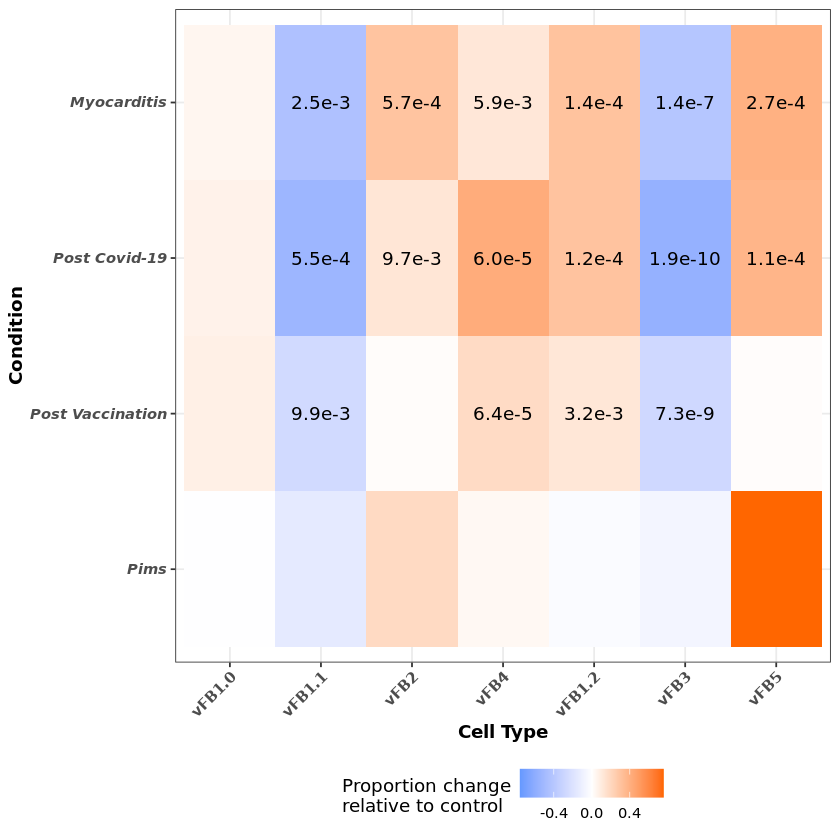

In [483]:
p1

In [484]:
#prop_ctrl <- y %>% dplyr::select(cellstate, mean.prop.ctrl) %>% group_by(cellstate) %>% slice_head(n=1)
p2 <- ggplot(aes(x=cellstate, y=mean.prop.ctrl*100, fill=cellstate), data=prop_ctrl) + geom_bar(stat="identity") + scale_fill_manual(values=cs_colmap) +
      geom_text(aes(y=mean.prop.ctrl * 100 + max(mean.prop.ctrl) * 4, label=signif(mean.prop.ctrl * 100, 2))) + labs(title=paste(""), y="Mean % in controls")  + no.xaxis + theme(legend.position = "none") + scale_x_discrete(drop=FALSE) + theme(axis.text.y=element_text(face="bold"), axis.title.y=element_text(face="bold"))

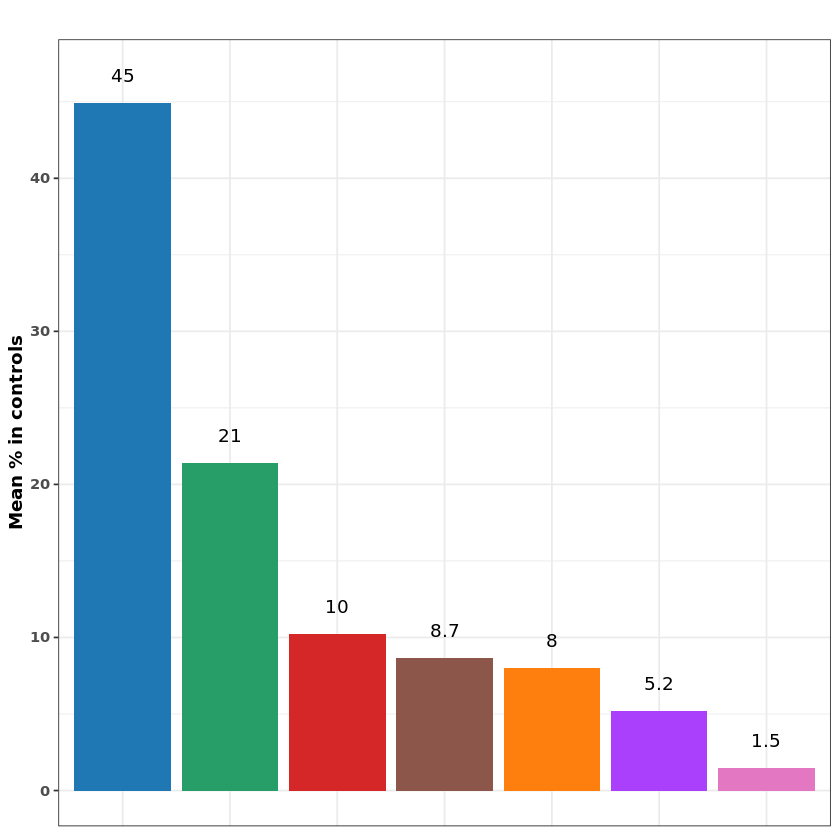

In [485]:
p2

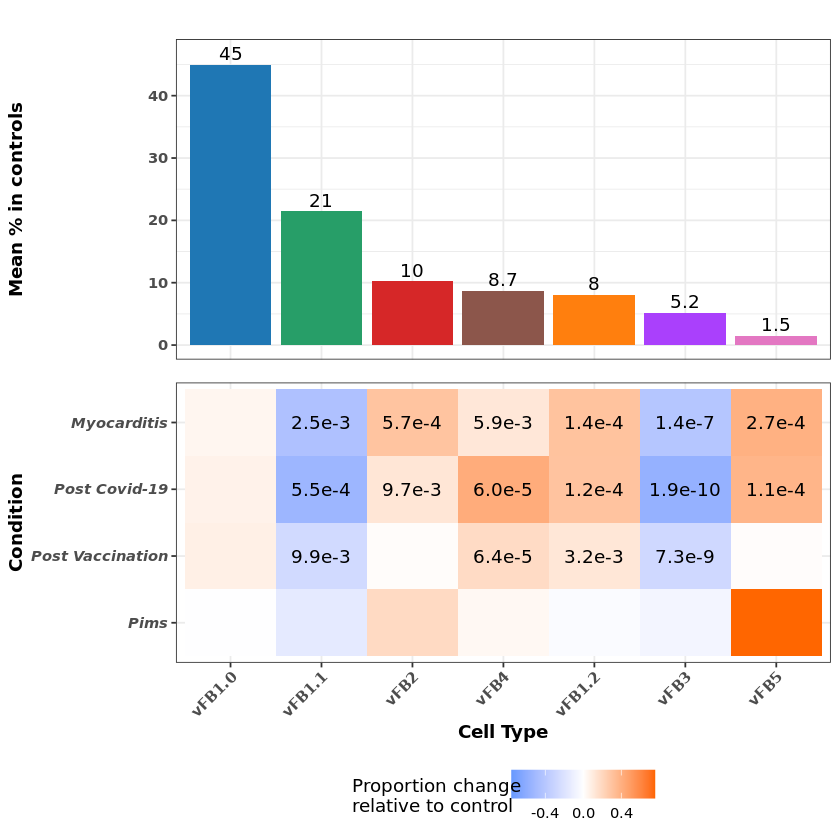

In [486]:
plot_all <- ggarrange(p2, p1, ncol=1, nrow=2, align="v", heights = c(4, 5))
plot_all

# Subclustering_CM

In [489]:
meta <- read.csv("/CM_OBS.csv")

In [490]:
meta$celltype_classified <- gsub("\\+ ", "_", meta$celltype_classified)
meta <- meta[which(as.character(meta$Condition_custom)!="Pims follow up"),]
meta <- meta[which(as.character(meta$celltype_classified)!="unassigned"),]
meta$Condition_custom <- as.factor(as.character(meta$Condition_custom))

In [491]:
META_CT <- meta

In [492]:
meta <- META_CT[META_CT$celltype_classified %in% c("CM"),]

In [493]:
meta <- meta[,c("Condition_custom", "Patient", 'cell_states')]
meta$Patient <- as.character(meta$Patient)
meta$Condition_custom <- as.character(meta$Condition_custom)
meta$cell_states <- as.character(meta$cell_states)
colnames(meta)[3] <- "leiden_annotated"

In [494]:
meta$leiden_annotated <- gsub("vCM_disease", "vCM6", meta$leiden_annotated)

# Themes ggplot

In [498]:
theme_set(theme_bw())
flipx <- theme(axis.text.x=element_text(angle=90, hjust=1))
flipx45 <- theme(axis.text.x=element_text(angle=45, hjust=1))
no.xaxis <- theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank())
erics_theme <- theme(axis.text.x = element_text(color = "black", size = 13, angle = 90, hjust = 1, vjust = 1, face = "bold"),
                     axis.text.y = element_text(color = "black", size = 13, angle = 0, hjust = 0, vjust = 0, face = "bold"),
                     axis.title.x = element_text(color = "black", size = 20, angle = 0, hjust = .5, vjust = 0, face = "bold"),
                     axis.title.y = element_text(color = "black", size = 20, angle = 90, hjust = .5, vjust = .5, face = "bold"),
                     legend.text = element_text(size=15, face = "bold"),
                     legend.title = element_text(size=15, face = "bold"),
                     strip.text.x = element_text(size=13, face = "bold")
                     )
axis_format <- theme(axis.text.x = element_text(face = "bold"), axis.text.y = element_text(face = "bold"), axis.title.x = element_text(face = "bold"), axis.title.y = element_text(face = "bold"))
axis_format_bi <- theme(axis.text.x = element_text(face = "bold.italic"), axis.text.y = element_text(face = "bold.italic"), axis.title.x = element_text(face = "bold"), axis.title.y = element_text(face = "bold"))                                     

In [499]:
cs_colmap <- c(
'vCM1' = '#1f77b4',
'vCM1.1' = '#ff7f0e',
'vCM1.2' = '#279e68',
'vCM1.3' = '#d62728',
'vCM2' = '#aa40fc',
'vCM3' = '#8c564b',
'vCM4' = '#e377c2',
'vCM5' = '#b5bd61',
'vCM6' = '#17becf' # vCM_disease

)


In [500]:
our_fill_scale_gradient2 <- scale_fill_gradient2(limits=function(old) c(-max(abs(old)), max(abs(old))), high="#FF6600", mid = "white", low="#6699FF")

In [502]:
meta <- mutate(meta,condition=Condition_custom)


In [503]:
get.count.matrix <- function(props, celltype_col, value_col) {
  frm <- as.formula(paste("Patient", celltype_col, sep="~"))
  ct <- cast(props, frm, value=value_col, fun.aggregate=mean, add.missing=TRUE, na.rm=TRUE)
  ct[is.na(ct)] <- 0
  rownames(ct) <- ct$Patient
  dn <- list(rownames(ct), colnames(ct)[-1])
  ct <- as.matrix(ct[,-1]) 
  dimnames(ct) <- dn
  return(ct)
}

get.proportion.matrix <- function(prop.coarse, celltype_col, pseudocount=0, value_col="proportion", impute_zeros=TRUE, imputation_method="cmultRepl") {
  ct <- get.count.matrix(prop.coarse, celltype_col, value_col)
  if (!impute_zeros) {
    ct <- ct + pseudocount ## add pseudo count
    ct <- ct / rowSums(ct) ## renormalise
  } else {
    library(zCompositions)
    all_missing <- apply(is.na(ct), 1, all)
    if (imputation_method == "cmultRepl") {
      ct[!all_missing,] <- as.matrix(cmultRepl(ct[!all_missing,], method="GBM"))
    } else if (imputation_method == "multRepl") {
      dlim <- 1 / (prop.coarse %>% group_by(Patient) %>% dplyr::select(total) %>% slice_head(n=1) %>% deframe())
      ct[!all_missing,] <- as.matrix(multRepl(ct[!all_missing,], dl=dlim[rownames(ct)[!all_missing]]))
    }
  }
  return(ct)
}

In [504]:
da.by.covariate <- function(ct, celltype, column) {
  #select <- covar[[column]] %in% groups # & !all.zero
  Z <- clr(acomp(ct))
  data <- data.frame(abundance=Z[,celltype], proportion=ct[,celltype],"Condition_custom"=ct[,column])#[select,]
#   data$group <- factor(data[,column], levels=groups)
  m <- lm(as.formula(paste("abundance ~", column)), data=data)
  smr <- t(coef(summary(m))[2,])
  m2 <- lm(as.formula(paste("proportion ~", column)), data=data)
  smr2 <- t(coef(summary(m2))[2,])
  colnames(smr2) <- paste("prop",colnames(smr2), sep="_")
  ## two ways to normalize (either to overall mean)
  mean.prop <- mean(data$proportion)
  ## or to mean in controls
  mean.prop.ctrl <- coef(m2)[1]
  return(data.frame(smr, smr2, mean.prop, mean.prop.ctrl, check.names=FALSE))
}


In [505]:
prop.coarse <- meta %>% group_by(leiden_annotated, Patient, Condition_custom) %>% summarise(count=n())



`summarise()` has grouped output by 'leiden_annotated', 'Patient'. You can override using the `.groups` argument.



In [506]:
prop.coarse

leiden_annotated,Patient,Condition_custom,count
<chr>,<chr>,<chr>,<int>
vCM1,BS_H15,Control,5219
vCM1,BS_H20,Control,4567
vCM1,BS_H25,Control,2472
vCM1,BS_H26,Control,1476
vCM1,BS_H35,Control,2151
vCM1,BS_H37,Control,2428
vCM1,CB_D1_,Control,1835
vCM1,CB_D2_,Control,1282
vCM1,CB_D4_,Control,2283


In [507]:
Eric_object <- get.proportion.matrix(prop.coarse, celltype_col = 'leiden_annotated',
                                     value_col = 'count')

Make count matrix for filtering

In [508]:
count_matrix_all <- get.count.matrix(prop.coarse, celltype_col = 'leiden_annotated',value_col = 'count')
count_matrix_all <- as.data.frame(as.matrix(count_matrix_all))

In [509]:
Patient_condition <- meta[-which(duplicated(meta[,"Patient"])),c("Patient", 'Condition_custom')]  #table(meta$Patient, meta$Patient)

In [510]:
count_matrix_all <- merge(count_matrix_all, Patient_condition, by.x="row.names", by.y="Patient")
head(count_matrix_all)

,Row.names,vCM1,vCM1.1,vCM1.2,vCM1.3,vCM2,vCM3,vCM4,vCM5,vCM6,Condition_custom
,<I<chr>>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,BS_H15,5219,508,560,891,1743,573,588,193,465,Control
2,BS_H20,4567,498,575,833,1286,933,595,150,450,Control
3,BS_H25,2472,409,393,440,605,349,295,116,243,Control
4,BS_H26,1476,234,284,230,404,143,104,43,155,Control
5,BS_H35,2151,281,308,498,596,283,244,65,202,Control
6,BS_H37,2428,260,298,543,705,296,333,57,242,Control


In [511]:
count_matrix_condition <- apply(count_matrix_all[,2:10], 
                                2, 
                                function(i) 
                                       tapply(X = i, 
                                              INDEX = count_matrix_all$Condition_custom, 
                                              mean)
                                   )

In [512]:
count_matrix_all_melt <- reshape2::melt(count_matrix_all)
colnames(count_matrix_all_melt) <- c("Patient", "Condition_custom", "leiden_annotated", "nind.gene")
head(count_matrix_all_melt)

Using Row.names, Condition_custom as id variables



,Patient,Condition_custom,leiden_annotated,nind.gene
,<I<chr>>,<chr>,<fct>,<dbl>
1,BS_H15,Control,vCM1,5219
2,BS_H20,Control,vCM1,4567
3,BS_H25,Control,vCM1,2472
4,BS_H26,Control,vCM1,1476
5,BS_H35,Control,vCM1,2151
6,BS_H37,Control,vCM1,2428


In [513]:
count_matrix_condition_melt <- reshape2::melt(count_matrix_condition)
colnames(count_matrix_condition_melt) <- c("Condition_custom", "leiden_annotated", "mean_count")
head(count_matrix_condition_melt)

,Condition_custom,leiden_annotated,mean_count
,<fct>,<fct>,<dbl>
1,Control,vCM1,1901.9444
2,Myocarditis,vCM1,288.2500
3,Pims,vCM1,277.5000
4,Post Covid-19,vCM1,449.3000
5,Post Vaccination,vCM1,226.7500
6,Control,vCM1.1,155.6667


Continue with values to plot

In [514]:
meta_ <- meta[-which(duplicated(meta$'Patient')),c('Patient','Condition_custom')]

In [515]:
Eric_object <- as.data.frame(as.matrix(Eric_object))


In [517]:
merged_object <- merge(Eric_object,meta_,by.y = 'Patient',by.x = 'row.names',all = TRUE)


In [518]:
head(merged_object)

,Row.names,vCM1,vCM1.1,vCM1.2,vCM1.3,vCM2,vCM3,vCM4,vCM5,vCM6,Condition_custom
,<I<chr>>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,BS_H15,0.4859404,0.04729981,0.05214153,0.08296089,0.1622905,0.05335196,0.05474860,0.01797020,0.04329609,Control
2,BS_H20,0.4619197,0.05036917,0.05815718,0.08425205,0.1300698,0.09436634,0.06018003,0.01517144,0.04551431,Control
3,BS_H25,0.4644870,0.07685081,0.07384442,0.08267569,0.1136791,0.06557685,0.05543029,0.02179632,0.04565953,Control
4,BS_H26,0.4803124,0.07614709,0.09241783,0.07484543,0.1314676,0.04653433,0.03384315,0.01399284,0.05043931,Control
5,BS_H35,0.4647796,0.06071737,0.06655143,0.10760588,0.1287813,0.06114952,0.05272256,0.01404494,0.04364736,Control
6,BS_H37,0.4703603,0.05036807,0.05772956,0.10519179,0.1365750,0.05734212,0.06450988,0.01104223,0.04688105,Control


In [520]:
Conditions_loop <- unique(merged_object$Condition_custom)[-1]

all_results_out <- list()

for (CONDITION in Conditions_loop){
    selected <- merged_object[which(merged_object[,'Condition_custom'] %in% c('Control',CONDITION)),]
    # Filter out patients with low number of all nuclei (if applicable, only relevant for cell-state analysis)
    selected <- selected[which(selected$Row.names %in% count_matrix_all[which(apply(count_matrix_all[,2:10], 1, sum)>=10),"Row.names"]),]
    print(table(selected$Condition_custom))
    
    # Define cell-types/states
    cell_type <- colnames(merged_object)[3:length(colnames(merged_object))-1]
    
    suppressWarnings({    
    if (length(unique(selected$Condition_custom))>1 &
        all(table(as.character(selected$Condition_custom))>=2)) {
    sapply_out <- lapply(cell_type, function(i) da.by.covariate(selected,celltype = c(i),column = 'Condition_custom'))
    sapply_out <- do.call("rbind", sapply_out)
    rownames(sapply_out) <- cell_type
    all_results_out[[CONDITION]] <- sapply_out
                         }
        })
}

    


#cell_type <- colnames(merged_object)[3:length(colnames(merged_object))-1]
#sapply_out <- lapply(cell_type, function(i) da.by.covariate(selected,celltype = c(i),column = 'Condition_custom'))
                    


    Control Myocarditis 
         18           8 

      Control Post Covid-19 
           18            10 

Control    Pims 
     18       2 

         Control Post Vaccination 
              18                4 


In [521]:
all_results_out_pV <- do.call("rbind", lapply(all_results_out, function(i) i[,'Pr(>|t|)']))
                                               
all_results_out_meanprop <- do.call("rbind", lapply(all_results_out, function(i) i[,'mean.prop.ctrl']))                                               
all_results_out_Est <- do.call("rbind", lapply(all_results_out, function(i) i[,'mean.prop']))                                               
                                               
colnames(all_results_out_pV) <- colnames(merged_object)[3:length(colnames(merged_object))-1]

In [522]:
all_results_out_meanprop

Myocarditis,0.4718174,0.03252424,0.0389487,0.08174276,0.1140116,0.09966667,0.096753,0.01633553,0.04820012
Post Covid-19,0.4718174,0.03252424,0.0389487,0.08174276,0.1140116,0.09966667,0.096753,0.01633553,0.04820012
Pims,0.4718174,0.03252424,0.0389487,0.08174276,0.1140116,0.09966667,0.096753,0.01633553,0.04820012
Post Vaccination,0.4718174,0.03252424,0.0389487,0.08174276,0.1140116,0.09966667,0.096753,0.01633553,0.04820012


In [523]:
all_results_out_Est

Myocarditis,0.4709076,0.02937080,0.03497692,0.09491291,0.1213615,0.08375050,0.08420905,0.01782086,0.06268991
Post Covid-19,0.4797761,0.02869702,0.03982234,0.09548164,0.1144069,0.08370224,0.07850154,0.02758278,0.05202944
Pims,0.4647962,0.03078502,0.03800728,0.08279145,0.1105150,0.10838233,0.08909506,0.01675364,0.05887405
Post Vaccination,0.4885160,0.02975977,0.03872312,0.08274799,0.1192660,0.08815784,0.08229151,0.01589828,0.05463946


In [524]:
FC_all <- all_results_out_Est/all_results_out_meanprop
colnames(FC_all) <- colnames(merged_object)[3:length(colnames(merged_object))-1]

In [525]:
FC_all <- melt(FC_all)
colnames(FC_all) <- c("celltype", "Condition_custom", "change")

In [526]:
all_results_out_pV <- melt(all_results_out_pV)
colnames(all_results_out_pV) <- c("celltype", "Condition_custom", "pV")

In [527]:
colnames(all_results_out_pV)

[1] "celltype"         "Condition_custom" "pV"

In [528]:
y <- merge(all_results_out_pV, FC_all, by=c("celltype", "Condition_custom"))

In [529]:
colnames(y)[1:2] <- c("gene", "cellstate")

In [530]:
y$change <- log2(y$change)

Define order of cell-types and Conditions

In [531]:
y$gene <- factor(as.character(y$gene), levels=rev(c("Myocarditis", "Post Covid-19", "Post Vaccination", "Pims")))

In [532]:
prop_ctrl <- data.frame(cellstate=colnames(merged_object)[3:length(colnames(merged_object))-1],
                         mean.prop.ctrl=all_results_out_meanprop[1,]
                        )

In [533]:
y$cellstate <- factor(y$cellstate, levels=prop_ctrl$cellstate[order(prop_ctrl$mean.prop.ctrl, decreasing = T)])

In [534]:
prop_ctrl$cellstate <- factor(prop_ctrl$cellstate, levels=prop_ctrl$cellstate[order(prop_ctrl$mean.prop.ctrl, decreasing = T)])

In [535]:
tmp <- split(y, y$gene)#, function(i) i$FDR3 <- p.adjust(i$pV, method = "BH")))
y <- do.call("rbind", lapply(tmp, function(i) cbind(i, 'FDR_per_analysis'=p.adjust(i$pV, method = "BH"))))

In [536]:
y[y$gene=="Pims","FDR_per_analysis"] <- 1

In [537]:

y[which(abs(y$change)<=0.1),"FDR_per_analysis"] <- 1

In [539]:
p1 <- ggplot(aes(x=cellstate, y=gene, fill=change), data=y) + geom_tile() + our_fill_scale_gradient2 + flipx45 + 
      labs(y="Condition", x="Cell Type", fill="Proportion change\nrelative to control") + theme(legend.position = "bottom") + scale_x_discrete(drop=FALSE) + axis_format + theme(axis.text.y=element_text(face="bold.italic"))
sig <- with(y, FDR_per_analysis < 0.05)# & (mean.count.ctrl > 5 | mean.count.gene > 5) & nind.gene >= 0)
if (any(sig)) {
    p1 <- p1 + geom_text(aes(x=cellstate, y=gene, label=gsub("e-0", "e-", formatC(pV, format="e", digits=1))), data=y[sig,])
}

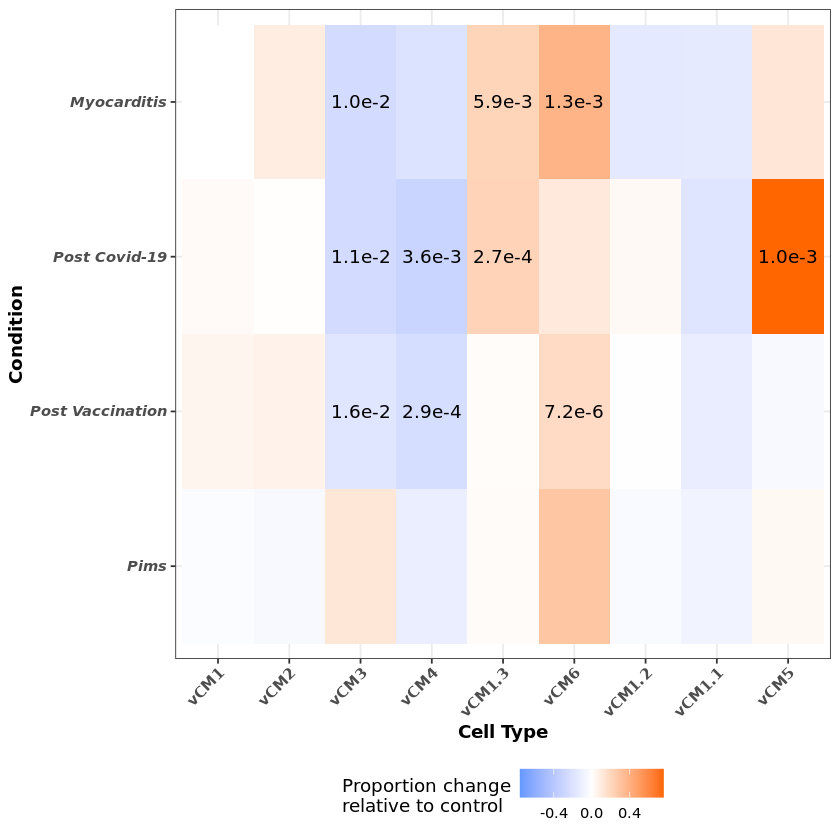

In [540]:
p1

In [541]:
p2 <- ggplot(aes(x=cellstate, y=mean.prop.ctrl*100, fill=cellstate), data=prop_ctrl) + geom_bar(stat="identity") + scale_fill_manual(values=cs_colmap) +
      geom_text(aes(y=mean.prop.ctrl * 100 + max(mean.prop.ctrl) * 4, label=signif(mean.prop.ctrl * 100, 2))) + labs(title=paste(""), y="Mean % in controls")  + no.xaxis + theme(legend.position = "none") + scale_x_discrete(drop=FALSE) + theme(axis.text.y=element_text(face="bold"), axis.title.y=element_text(face="bold"))

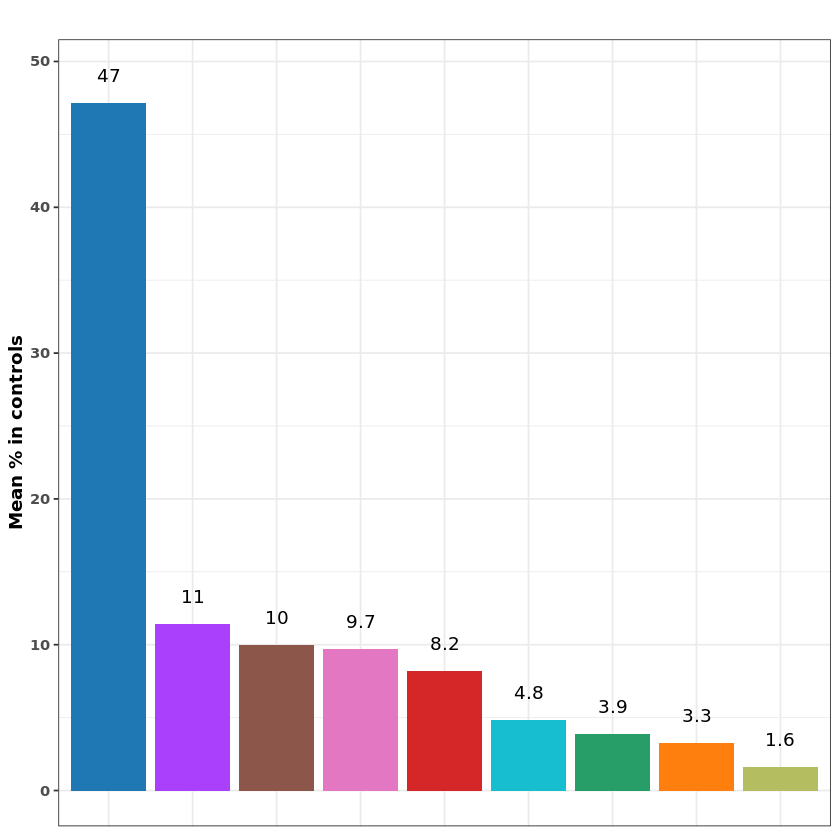

In [542]:
p2

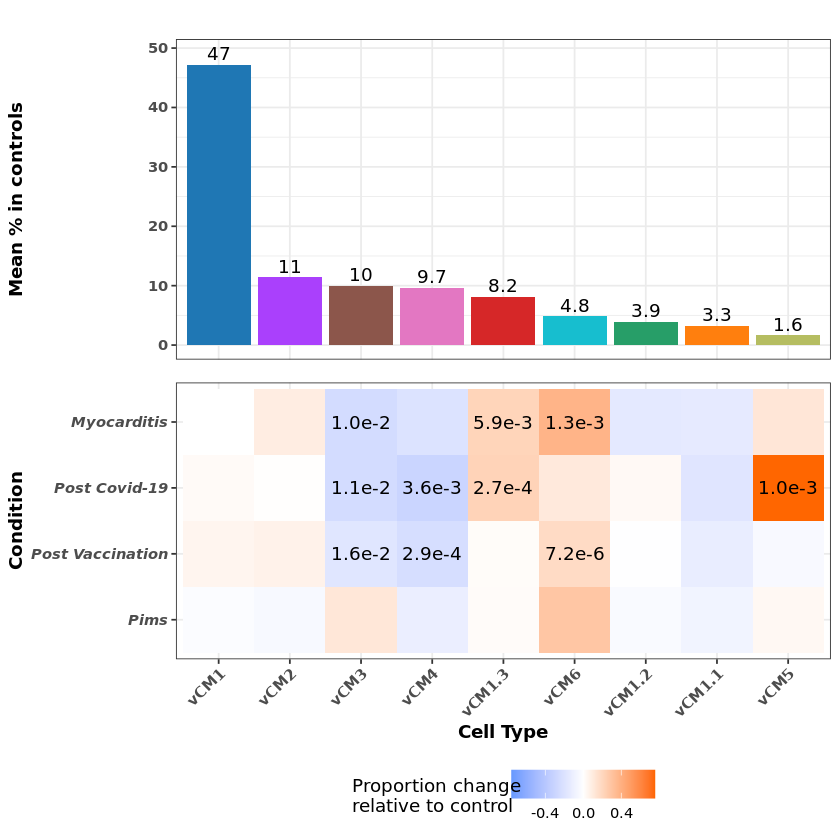

In [543]:
plot_all <- ggarrange(p2, p1, ncol=1, nrow=2, align="v", heights = c(4, 5))
plot_all